In [1]:
#| echo: false
import numpy as np 
import math
import pandas as pd
import numpy.random as rn
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm 
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score 

In [2]:
#| echo: false  # Hides the code from output

## **Part I: Data Wrangling**

In [4]:
#| echo: false
EVI_df = pd.read_csv("PltEVI.csv", header=None)
Height_df = pd.read_csv("PltHeight.csv", header=None)
HSUS_df = pd.read_csv("PltHSUS.csv", header=None)
Immigration_df = pd.read_csv("PltImmigration.csv", header=None)
lifex_df = pd.read_csv("PltLifeExpectancy.csv",header=None)
Polarization_df = pd.read_csv("PltPolarization.csv",header=None)
WageGDPRatio_df = pd.read_csv("PltWageGDPRatio.csv",header=None)
USPV_df = df = pd.read_excel('USPVdatabase.xlsx')

To wrangle the data we first loaded in all the individual dataframes. We created a dataframe called “years” with every year from 1610 to 2010 to use for easier merging of all of our dataframes.

For *Immigration* we assigned column names, and then converted the “year” column to a string, extracted the first four digits, and converted it back to an integer. We grouped by year and took the mean value (because there are multiple values per year, and we do not know which one is more accurate) of the “foreign_born_mil” column to ultimately create an immigration df with the full range of years after merging with “years” and filling in NaN values. Finally, we interpolated the missing values using linear interpolation on the “foreign_born_mil” column. For *Wealth Inequality (EVI)* we did the exact same steps to create a df for years from 1790 to 2010, for *Height Expectancy* we did the exact same steps to create a df for years from 1740 to 1970, and finally for *Life Expectancy* we did the exact same steps to create a df for years from 1740 to 1971.

For *Wealth Inequality (HSUS)* we assigned column names and converted the year values to integers. Then, we grouped by year and took the mean value of the HSUS column to create a df for years from 1790 to 1999. We merged this with the full “years” range and interpolated the missing HSUS values using linear interpolaation. For *Political Polarization* we did the exact same thing to create a df for years from 1790 to 2011. We merged with the full “years” range and interpolated using linear interpolation. For *Wage/GDP Ratio* we did the exact same steps to create a df for years from 1790 to 2010.

We finished this section by creating “merged_df” by ‘outer’ merging all of the dataframes on ‘year’, renaming the columns, and filling in ‘NaN’ where needed. 

Then, we got started calculating the *Political Instability Index.* 

We created “census_df” with the population data we would need to calculate the political instability index. We could only find population data online in the years that the census was taken, so we loaded in that data to create a census df with 5-year intervals from 1610-2010. We merged this census data with “years,” ensuring data aligns with 5-year increments. We then created a scatter plot of population data to figure out that we needed to apply a logarithmic transformation to make the “census_clean” data linear, and so that we could interpolate using the linear method (since log-transformed data should follow a linear pattern). Then we reversed the logarithmic transformation (took the exponential) of population and dropped the intermediate log_population column to keep just the “Population” column and transformed it into millions. The scatterplot showed an exponential trend in population, but because the interpolate function doesn’t have an exponential feature we had to use the log-transformation round-about way of getting an exponential transformation. At this point, we filtered the data from 1780 onward (our census data started in 1610 but the earliest year from our other data was 1780) & plotted it to make sure that everything looked right.

We loaded in the USPV_df (largest fortunes in the US) and converted the year column to integer format. We ensured the fatalities column contains valid numeric values and removed rows with missing data. We grouped the fatalities data by year and summed up fatalities per year, ensuring fatalities data aligns with census year intervals and replaces missing values with 0. We assigned each year to a 5-year period by rounding down and summed fatalities over each 5-year period. We converted periods into readable ranges (e.g., "1780-1785") and adjusted one instance of zero fatalities to avoid taking the logarithm of zero.

Finally, we calculated the *Political Instability Index* by computing deaths per million people per 5-year period. We applied a logarithmic transformation to the instability metric to find the instability index variable as described in the codebook, and then compiled period ranges, fatalities, population data, and instability values into a single df. We removed an index that was causing issues with calculations and expanded the dataset so that each 5-year period contained individual year entries. We merged the Political Instability Index with the other data (“merged_df”) and renamed columns for better readability. We printed the resulting df of all data (PII and “merged_df”) and saw which rows contained mostly NaN values, and droped these specific indices (0, 75 and 230, 271) before resetting the index to create “clean_total_df” which we will use for the rest of our analsyis.

We did not apply Standard Scaler to this df yet, but do so later in our analysis.

In [6]:
#| echo: false
#Extreme Value Index (EVI), the largest privately held fortune (excluding those held by rulers) is identified or estimated. 
#The largest U.S. fortune is then divided by the median annual wage, which represents a typical non-elite wage.
#This scaled wealth is typically shown on a log scale. 
#CAROLINE
#print(EVI_df.shape)
headers = ['year', 'EVI']
EVI_df.columns = headers
#EVI_df.head(), EVI_df.tail()
#EVI_df[0]

In [7]:
#| echo: false  # Hides the code from output

EVI_df['year'] = EVI_df['year'].astype(str).str[:4].astype(int)

EVI_df = pd.DataFrame(EVI_df.groupby('year', as_index=False)['EVI'].mean())

EVI_df

#plug in the year values for the first and last row
EVI_years = pd.DataFrame(
    {"year": range(1790,2010)})

evi = pd.merge(EVI_df, EVI_years, how='outer', left_on = 'year', right_on = 'year')

evi['EVI'] = evi['EVI'].interpolate(method='linear')
#evi

In [8]:
#| echo: false
#Biological proxies of well-being: average population height of native-born American men and life expectancy at 10 years of age. 
#Data were calculated for cohorts by the year of birth.
#CAROLINE
#print(Height_df.shape)
headers = ['year', 'Height']
Height_df.columns = headers
#Height_df.head(), Height_df.tail()

In [9]:
#| echo: false
#HEIGHT
Height_df['year'] = Height_df['year'].astype(str).str[:4].astype(int)

Height_df = pd.DataFrame(Height_df.groupby('year', as_index=False)['Height'].mean())

#print(Height_df)

#plug in the year values for the first and last row
pltheight_years = pd.DataFrame(
    {"year": range(1740,1970)})

height = pd.merge(Height_df, pltheight_years, how='outer', left_on = 'year', right_on = 'year')

height['Height'] = height['Height'].interpolate(method='linear')
#height

In [10]:
#| echo: false
#The HSUS percentages are estimates of
#the percentages of total wealth held by the top one percent (by net worth).
#CONSTANCE

#print(HSUS_df.shape)
headers = ['year', 'HSUS']
HSUS_df.columns = headers
#print(HSUS_df.head(10))
HSUS_df.year = HSUS_df.year.astype(int) #This method will round down any decimal points
HSUS_years_clean = HSUS_df.groupby(HSUS_df.year)['HSUS'].mean()
HSUS_years_clean = HSUS_years_clean.to_frame()
#print(HSUS_years_clean)
years = pd.DataFrame(
    {"year": range(1790,1999)})
#print(years)
HSUS_clean = pd.merge(years, HSUS_years_clean, how='outer', left_on = 'year', right_on = 'year')
#print(HSUS_clean)
HSUS_clean['HSUS'] = HSUS_clean['HSUS'].interpolate(method='linear')
#HSUS_clean

In [11]:
#| echo: false
#Proportion of population that was born outside the U.S.
#CAROLINE
#print(Immigration_df.shape)
headers = ['year', 'Foreign born?']
Immigration_df.columns = headers
#Immigration_df.head(), Immigration_df.tail()

In [12]:
#| echo: false
#IMMIGRATION
Immigration_df['year'] = Immigration_df['year'].astype(str).str[:4].astype(int)

#make sure all of these rows has pd.DataFrame around the thing...
Immigration_df = pd.DataFrame(Immigration_df.groupby('year', as_index=False)['Foreign born?'].mean())

#stop code here first to see the year values in the first and last row
Immigration_df

#plug in the year values for the first and last row
immigration_years = pd.DataFrame(
    {"year": range(1815,2005)})

immigration = pd.merge(Immigration_df, immigration_years, how='outer', left_on = 'year', right_on = 'year')

immigration['Foreign born?'] = immigration['Foreign born?'].interpolate(method='linear')
#immigration

In [13]:
#| echo: false
#Biological proxies of well-being: average population height of native-born American men and life expectancy at 10 years of age.
#CAROLINE
#print(lifex_df.shape)
headers = ['IndexDup','year', 'life_ex']
lifex_df.columns = headers
lifex_df.drop(columns='IndexDup', inplace=True)
#lifex_df.head(), lifex_df.tail()

In [14]:
#| echo: false
#LIFE EXPECTANCY
lifex_df.columns = ['year', 'life_ex']

lifex_df['year'] = lifex_df['year'].astype(str).str[:4].astype(int)

lifex_df = pd.DataFrame(lifex_df.groupby('year', as_index=False)['life_ex'].mean())

lifex_df

#plug in the year values for the first and last row
lifex_years = pd.DataFrame(
    {"year": range(1740,1971)})

lifeexpectancy = pd.merge(lifex_df, lifex_years, how='outer', left_on = 'year', right_on = 'year')

lifeexpectancy['life_ex'] = lifeexpectancy['life_ex'].interpolate(method='linear')
#lifeexpectancy

In [15]:
#| echo: false
#The index is based on an analysis of voting patterns in the U.S. Congress that quantify polarization among
#the American political elites (a proxy for intra-elite Competition and Conflict). In brief, members
#of Congress are scored by a diﬀerent position on a liberal-conservative spectrum (e.g., by
#liberal interest groups as the Americans for Democratic Action or the United Auto Workers and
#conservative ones like the American Conservative Union or the National Taxpayers Union. A
#measure of political polarization is the distance between the average scores of the Democrats
#and the Republicans, calculated for each Congress (that is, every two years).
#CONSTANCE

#print(Polarization_df.shape)
headers = ['year', 'Polarization']
Polarization_df.columns = headers
#print(Polarization_df.head())
Polarization_df.year = Polarization_df.year.astype(int) #This method will round down any decimal points
Polarization_years_clean = Polarization_df.groupby(Polarization_df.year)['Polarization'].mean()
Polarization_years_clean = Polarization_years_clean.to_frame()
#print(Polarization_years_clean)
years = pd.DataFrame(
    {"year": range(1790,2011)})
#print(years)
Polarization_clean = pd.merge(years, Polarization_years_clean, how='outer', left_on = 'year', right_on = 'year')
#print(Polarization_clean)
Polarization_clean['Polarization'] = Polarization_clean['Polarization'].interpolate(method='linear')
#Polarization_clean

In [16]:
#| echo: false
#Wage/GDP ratio for blue-collar workers (index, 1860 = 1).
#CONSTANCE
#print(WageGDPRatio_df.shape)
headers = ['year', 'Wage-GDP Ratio']
WageGDPRatio_df.columns = headers
WageGDPRatio_df.head()

WageGDPRatio_df.year = WageGDPRatio_df.year.astype(int) #This method will round down any decimal points
WageGDPRatio_years_clean = WageGDPRatio_df.groupby(WageGDPRatio_df.year)['Wage-GDP Ratio'].mean()
WageGDPRatio_years_clean = WageGDPRatio_years_clean.to_frame()
#print(WageGDPRatio_years_clean)
years = pd.DataFrame(
    {"year": range(1790,2010)})
#print(years)
WageGDPRatio_clean = pd.merge(years, WageGDPRatio_years_clean, how='outer', left_on = 'year', right_on = 'year')
#print(WageGDPRatio_clean)
WageGDPRatio_clean['Wage-GDP Ratio'] = WageGDPRatio_clean['Wage-GDP Ratio'].interpolate(method='linear')
#WageGDPRatio_clean

In [17]:
#| echo: false
#The instability variable is the log-transformed number of people killed in
#instability events per one million population per 5 years.
#print(USPV_df.shape)
#USPV_df.head()

In [18]:
#| echo: false
USPV_df.year = USPV_df.year.astype(int) #This method will round down any decimal points
#print(USPV_df.dtypes)
USPV_df['fatalities'] = pd.to_numeric(USPV_df['fatalities'], errors='coerce')
USPV_df['fatalities'].isna().sum()
#drop the 6 NaN values
USPV_df.dropna(subset=['fatalities'], inplace=True)
#USPV_df['fatalities'].isna().sum()
USPV_years_clean = USPV_df.groupby(USPV_df.year)['fatalities'].sum()
USPV_years_clean = USPV_years_clean.to_frame()
#USPV_years_clean

In [19]:
#| echo: false
#need a df with year ranges in 5 year increments from 1782-2010:
years = pd.DataFrame(
    {"year": range(1780,2011)})
fatalities_clean = pd.merge(years, USPV_years_clean, how='outer', left_on = 'year', right_on = 'year')
fatalities_clean.fillna(0, inplace=True)
#fatalities_clean


In [20]:
#| echo: false
# Create a new column for the 5-year period
fatalities_clean['period'] = (fatalities_clean['year'] // 5) * 5 #divides by 5, rounds down, then multiplies by 5
#fatalities_clean

In [21]:
#| echo: false
# Create a new DataFrame by grouping by the 5-year period and summing the fatalities
fatalities_by_period = fatalities_clean.groupby('period')['fatalities'].sum().reset_index()

# period as a range (e.g., '1780-1785')
fatalities_by_period['period_range'] = fatalities_by_period['period'].astype(str) + '-' + (fatalities_by_period['period'] + 5).astype(str)
fatalities_by_period.drop(columns='period',inplace=True)
fatalities_by_period.loc[fatalities_by_period.fatalities == 0] #only at index 8 do we have 0 fatalities. want to change this to avoid log issues
fatalities_by_period.iloc[8, 0] = 0.00001
#fatalities_by_period.head(10)

In [22]:
#| echo: false
Census_df = pd.read_excel('census_population.xlsx')
Census_df.head(), Census_df.tail()
years = pd.DataFrame(
    {"year": range(1610,2011,5)})
Census_clean = pd.merge(years, Census_df, how='outer', left_on = 'year', right_on = 'Census Year')
#Census_clean

In [23]:
#| echo: false
#plt.scatter(Census_clean['Census Year'], Census_clean['Population'])
#plt.xlabel('Census Year')
#plt.ylabel('Population')
#need to do exponential interpolation!

In [24]:
#| echo: false
#Apply a logarithmic transformation to make the data linear
Census_clean['log_population'] = np.log(Census_clean['Population'])

#plt.scatter(Census_clean['Census Year'], Census_clean['log_population'])
#plt.xlabel('Census Year')
#plt.ylabel('Log Population')

In [25]:
#| echo: false
#Interpolate using the linear method (since log-transformed data should follow a linear pattern)
Census_clean['log_population'] = Census_clean['log_population'].interpolate(method='linear')

#Reverse the logarithmic transformation (take the exponential)
Census_clean['Population'] = np.exp(Census_clean['log_population'])

# Drop the intermediate log column
Census_clean.drop(columns='log_population', inplace=True)
Census_clean.drop(columns="Census Year", inplace=True)
#Census_clean

In [26]:
#| echo: false
Census_clean["Population_in_millions"] = Census_clean.Population/1000000
#Census_clean.head()
#Census_clean.isna().sum()

In [27]:
#| echo: false
census_in_range = Census_clean.loc[Census_clean.year>=1780][['year','Population_in_millions']]
census_in_range.reset_index(inplace=True, drop=True)
#census_in_range.head()

In [28]:
#| echo: false
#plt.scatter(census_in_range['year'], census_in_range['Population_in_millions'])
#plt.xlabel('Year')
#plt.ylabel('Population, Interpolated')
#plt.title("Interpolated Population Data")

In [29]:
#| echo: false
#What population value to use for the 5 year period? e.g., if we are looking at 1610-1615, do we use 1610 population or 1615 population?
# The instability variable is the log-transformed number of people killed in instability events per one million population per 5 years.
#We have one -inf value under Instability (see index = 8). what do we do with that?

Deaths = fatalities_by_period.fatalities/census_in_range.Population_in_millions

PII_df = pd.DataFrame(
    {'Period_Range': fatalities_by_period.period_range,
     '5 Year Fatalities': fatalities_by_period.fatalities,
     'Census Year': census_in_range.year,
    'Population for Census Year': census_in_range.Population_in_millions,
    'Instability': np.log(Deaths)})
#PII_df.head(9)
#PII_df.tail()  #goes til 2015
PII_df.drop(PII_df.index[46], inplace=True) #2010-2015 row
#PII_df.tail()  #goes til 2015

In [30]:
#| echo: false
PII_df['All Years'] = PII_df['Census Year'].apply(lambda x: list(range(x, x+5)))

# Expand the DataFrame by exploding the 'All Years' column
expanded_df = PII_df.explode('All Years')

expanded_df = expanded_df.rename(columns={'All Years': 'year'})

expanded_df = expanded_df.reset_index(drop=True)

expanded_df.head(30)
PII_merge = expanded_df[["Instability","year"]]
#PII_merge

In [31]:
#| echo: false
#Merging all 7 dfs: Caroline sent the code
dfs = [immigration, evi, height, lifeexpectancy, HSUS_clean, Polarization_clean, WageGDPRatio_clean, PII_merge]

merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.merge(df, on='year', how='outer')

merged_df = merged_df.rename(columns={
    'year': 'Year',
    'Foreign born?': 'Foreign_Born',
    'evi': 'EVI',
    'height': 'Height',
    'life_ex': 'Life_Ex',
    'Wage-GDP Ratio': 'Wage_Ratio'
})

merged_df.tail(50) #NaN values begin in 1970, last row to include is index 229
merged_df.head(76) #NaN values end in 1814, first row to include is index 75
clean_total_df = merged_df.iloc[75: 230]
clean_total_df = clean_total_df.reset_index(drop=True)
#clean_total_df

**Display the DataFrame with all of the columns and the interpolated data for the years
1901-1910.**

In [33]:
#| echo: false
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Allow the table to stretch to the width of the content

relevant_rows = merged_df.loc[(merged_df['Year'] >= 1901) & (merged_df['Year'] <= 1910)]
relevant_rows

# Define the number of columns per chunk
chunk_size = 5 
num_chunks = len(relevant_rows.columns) // chunk_size + 1

# Split the dataframe into chunks
chunks = [relevant_rows.iloc[:, i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]

# Render each chunk in Quarto
for i, chunk in enumerate(chunks):
    print(f"### Part {i+1}")
    print(chunk.to_markdown(index=False))  # Render as markdown for Quarto


### Part 1
|   Year |   Foreign_Born |     EVI |   Height |   Life_Ex |
|-------:|---------------:|--------:|---------:|----------:|
|   1901 |        13.7993 | 1474.49 |  170.328 |   50.4225 |
|   1902 |        13.8968 | 1566.71 |  170.501 |   50.5717 |
|   1903 |        13.9877 | 1667.19 |  170.672 |   50.7424 |
|   1904 |        14.0936 | 1739.17 |  170.887 |   50.9017 |
|   1905 |        14.1996 | 1850.34 |  171.105 |   51.061  |
|   1906 |        14.34   | 1965.17 |  171.33  |   51.2042 |
|   1907 |        14.4838 | 2051.36 |  171.562 |   51.3474 |
|   1908 |        14.5763 | 2182.49 |  171.782 |   51.5352 |
|   1909 |        14.6739 | 2325.6  |  172.016 |   51.723  |
|   1910 |        14.6201 | 2419.6  |  172.188 |   51.8904 |
### Part 2
|    HSUS |   Polarization |   Wage_Ratio |   Instability |
|--------:|---------------:|-------------:|--------------:|
| 30.7051 |       0.845472 |     0.651275 |      0.58646  |
| 31.2925 |       0.860217 |     0.64518  |      0.58646  |
| 31.8

## **Part II: Exploratory Data Analysis:**

In order to explore our data, we printed .info(), .describe(), and created a correlation matrix using sns.heatmap for the relevant_rows df from the previous question. Then, we did the same for “clean_total_df” which included rows from 1815-1969 (these were the years without missing data), not just rows from 1901-1910. We spent most of our time discussing these results, because clean_total_df is what we do the rest of our data analysis on for this final. Finally, we printed line plots of each variable over time in order to observe chronological trends and any particularly notable years or time periods.

In [36]:
#| echo: false
#relevant_rows.info()
#clean_total_df.info()

In [37]:
#| echo: false
#relevant_rows.describe()

In [38]:
#| echo: false
#clean_total_df.describe()

In [39]:
#| echo: false
#import seaborn as sns
#import matplotlib.pyplot as plt

#correlation_matrix = relevant_rows.corr()
#plt.figure(figsize=(10, 6))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

#plt.title("Correlation Matrix for relevant_rows")
#plt.show()

#relevant_rows.corr()
#merged_df.corr()

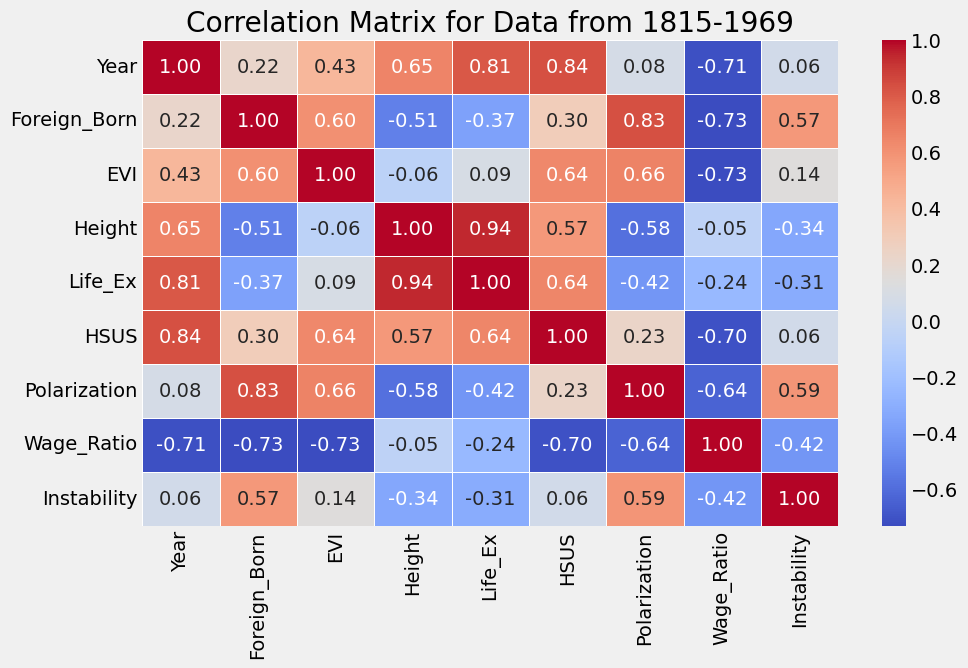

In [40]:
#| echo: false
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = clean_total_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

plt.title("Correlation Matrix for Data from 1815-1969")
plt.show()

Observing the correlation matrix, we notice that all of the indicators of economic inequality (EVI, HSUS, Wage Ratio) were relatively highly correlated, which we would expect, as well as all of the indicators having some correlation with year, which we also expect as there are trends over time that wouldn't randomly and sharply change year-over-year. Aside from Height and Life Exp (0.94), which we expect to be highly correlated because the two are indicators of health, there were a few highly correlated pairs of particular features which we found particularly interesting. Polarization and Foreign Born were highly correlated (0.83) which makes sense to us as anti-immigrant sentiment has historically mattered for political polarization and still plays a major role in political polarization today. Foreign Born and Wage Ratio were also highly negatively correlated (-0.73), which might reflect immigrants being more willing to work lower wage jobs after emigrating countries or being taken advantage of in their non-native language/country.

In [42]:
#| echo: false
#line graph
#sns.set_style("whitegrid")

#variables = ['EVI', 'Foreign_Born', 'Height', 'HSUS', 'Life_Ex', 'Polarization', 'Wage_Ratio', 'Instability']

#plt.figure(figsize=(12, 12))

#for i, col in enumerate(variables, 1):
 #   plt.subplot(4, 2, i)  # Create a 4-row, 2-column grid of subplots
 #   sns.lineplot(data=relevant_rows, x='Year', y=col, marker="o", linewidth=2)
 #   plt.title(f"{col} Over Time")
 #   plt.xlabel("Year")
#    plt.ylabel(col)

#plt.tight_layout()
#plt.show()


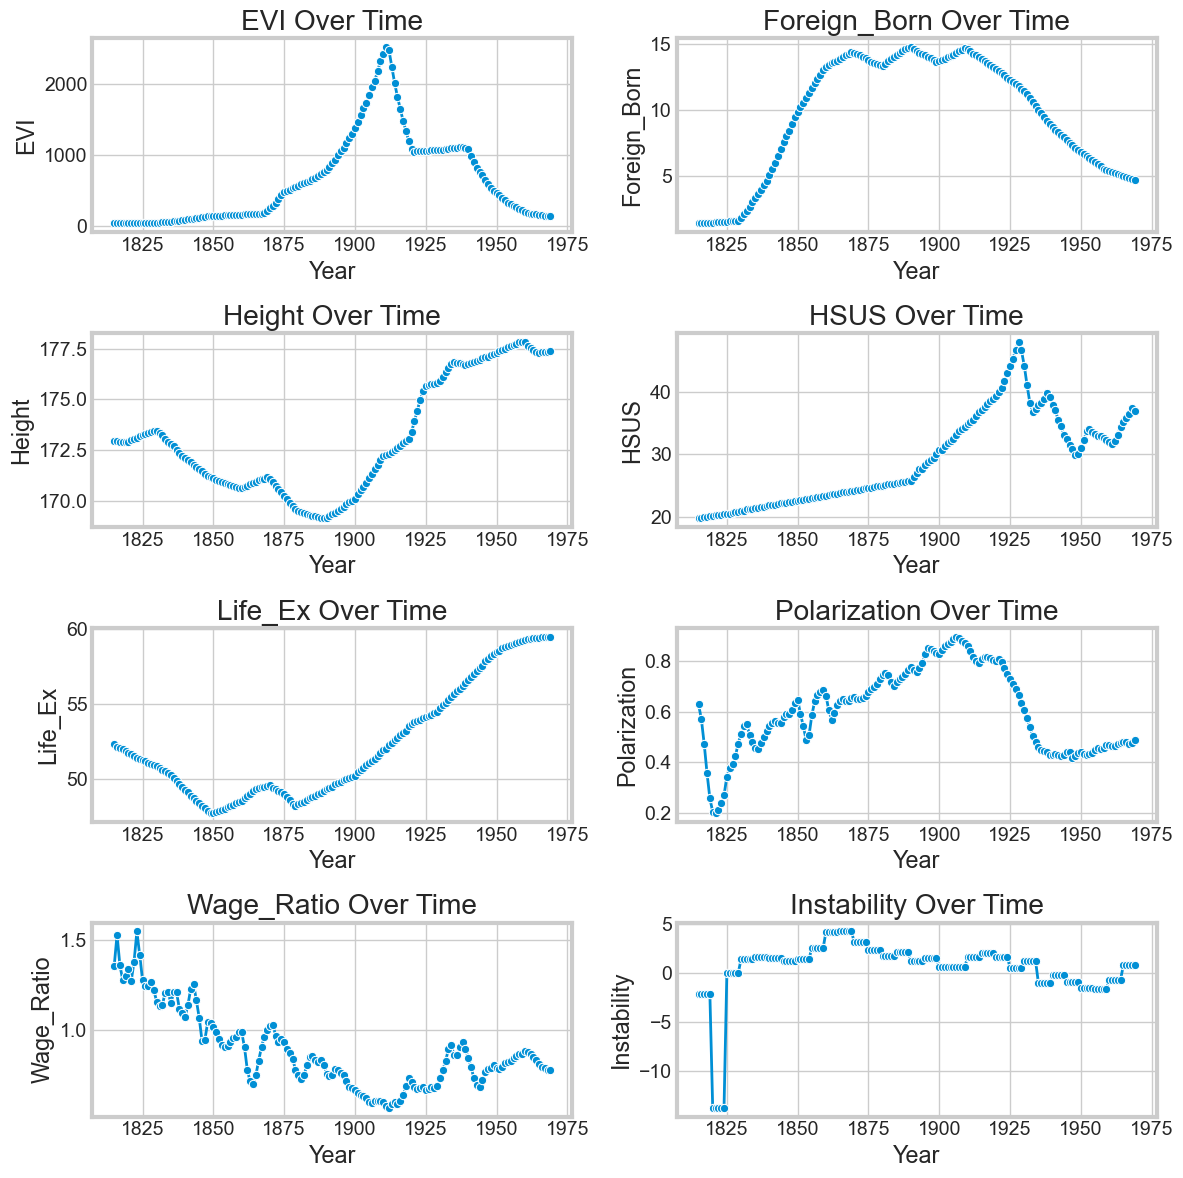

In [43]:
#| echo: false
sns.set_style("whitegrid")

variables = ['EVI', 'Foreign_Born', 'Height', 'HSUS', 'Life_Ex', 'Polarization', 'Wage_Ratio', 'Instability']

plt.figure(figsize=(12, 12))

for i, col in enumerate(variables, 1):
    plt.subplot(4, 2, i)  # Create a 4-row, 2-column grid of subplots
    sns.lineplot(data=clean_total_df, x='Year', y=col, marker="o", linewidth=2)
    plt.title(f"{col} Over Time")
    plt.xlabel("Year")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

Description of all graphs:

- For EVI: After rising somewhat exponentially, EVI sharply peaks around 1910. It has a dramatic fall off at 1915 and generally keeps falling for all years afterwards. This gives the graph a pyramid-like shape.
 
- For Foreign Born (in millions) over time: For most of the time, it stays between 13 and 15 million. The graph has an inverted U shape, with one large hump from 1860-1920.

- For Height: It has a general decreasing trend until 1890. Then, it rapidly increases for the rest of the time period.
 
- For HSUS: Similarly to EVI, there's a slow and steady increase until 1890, before a steeper increase until the late 1920s, when the graph peaks. Then, HSUS sharply falls, aligning with the Great Depression. In the years afterwards, it rises and falls turbulently but never getting close to the peak again.

- For Life Expectancy: This graph has roughly a W shape. It rises steadily after 1880.

- For Polarization: It rapidly rises and falls in 1820 before having a generally positive trend until 1920, after which it decreases (at first rapidly and then more gradually).

- For Wage-GDP Ratio: The graph is not a smooth line, rising and falling a lot, but it does have a general downward trend.

- For Instability: Instability is calculated in 5 year increments so we see a step like function. There is a dramatic minimum before 1825. Then, instability bounces back to pre-1825 levels and rises and falls in the years afterwards. It has a local maximum from 1860-70. 

Note: the y-axes are scaled with values that make sense for the data. However, this might mean that some trends appear less/more dramatic than they actually are.

These graphs all look very different from each other (aside from Life and Height Expectancy, which mirrored each other, but this is to be expected). We considered all these differences in the graphs to be a good thing because it indicates that the features are not highly collinear.

## **Part III: Find the best regressor that would predict the instability index from the various predictors.**

**Reasoning:**
In order to decide which regressors to compare, we first considered whether our data (clean_total_df) was well suited to any particular regressor.

A Gaussian Naive Bayes (NB) model tends to work well for data where features are independent and follow a normal distribution. It is ideal for scenarios with numerical data and any situation where you have continuous data and need to predict a categorical outcome. Although the features of clean_total_df are independent from each other, none of the features follow a normal distribution. Additionally, we are not trying to predict a categorical outcome. So, we decided not to compare a Gaussian Naive Bayes (NB) model.

Logistic Regression models are particularly good for predicting the probability of a binary outcome based on one or more independent variables. The dependent variable in a logistic regression model can only take on two values, which does not work for what we are trying to predict (numerical PII value), so we decided not to compare it.

Lasso (Least Absolute Shrinkage and Selection Operator) Regression is useful for feature selection and regularization, as it applies an L1 penalty that can shrink some coefficients to zero. This makes it particularly effective when dealing with high-dimensional data or datasets with many irrelevant features. Since our dataset includes multiple predictors, some of which may have little influence on the target variable (PII), we decided to include Lasso regression to evaluate its performance.

Ridge Regression is another form of regularization that, unlike Lasso, applies an L2 penalty, which shrinks all coefficients but does not set any to zero. This helps prevent overfitting, especially when features are highly correlated. Given that our dataset includes highly correlated features (i.e. height and life expectancy), Ridge regression is a good candidate for comparison.

Decision Trees are non-linear models that split data based on feature values, making them useful for capturing complex relationships between variables. Unlike linear models, decision trees do not assume independence or normality in features. Since our features do not follow a normal distribution and may have non-linear relationships, decision trees provide a flexible alternative to compare against linear regressors. There are a few types of decision tree models which we consider including in our regression comparison.

A Random Forest Decision Tree Model constructs multiple trees using random subsets of data and features, then averages (regression) or takes a majority vote (classification) for the final prediction. This type of model is best for high-dimensional datasets with many features, and our dataset does have many features. This model is also good at handling missing data and feature interactions, which our dataset includes. Finally, this model is good at reducing overfitting compared to a single decision tree, which is important for our analysis since some features are highly correlated. For these reasons, we decided to include this model in our comparison.

Gradient Boosted Trees are good for handling more complex datasets when the relationship between features is non-linear and when more intricate patterns exist in the data. They work well for multiclass classification, are comparatively less likely to overfit, and are not very sensitive to outliers. Finally, they perform well with large datasets and because each subsequent tree tries to correct the errors (residuals) made by the previous trees, they lead to a more directed learning process. This results in more precise corrections of the errors made by previous trees, which is beneficial for fine-tuning a model. We decided to try Gradient Boosted Trees as well.

Ultimately, we decided to compare Lasso Regression, Ridge Regression, Random Forest Decision Tree Model, and a Gradient Boost Decision Tree Model.

## **Lasso Model**

In [50]:
#| echo: false
X = clean_total_df.drop(columns='Instability')
y = clean_total_df.Instability

In [51]:
#| echo: false
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # X_test is your test data
#X_train_scaled 

In [52]:
#| echo: false
#Lasso Model:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=10, max_iter=10000)
lasso.fit(X_train_scaled, y_train.values.flatten())
best_alpha = lasso.alpha_
#print(f'Best Alpha: {best_alpha}')

#lasso.intercept_, lasso.coef_, lasso.score(X_train_scaled,y_train.values.flatten())

In [53]:
#| echo: false
from sklearn.metrics import mean_squared_error
y_preds = lasso.predict(X_test_scaled)
y_preds

mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error for Lasso Model: {mse}")

Mean Squared Error for Lasso Model: 3.2642029557245364


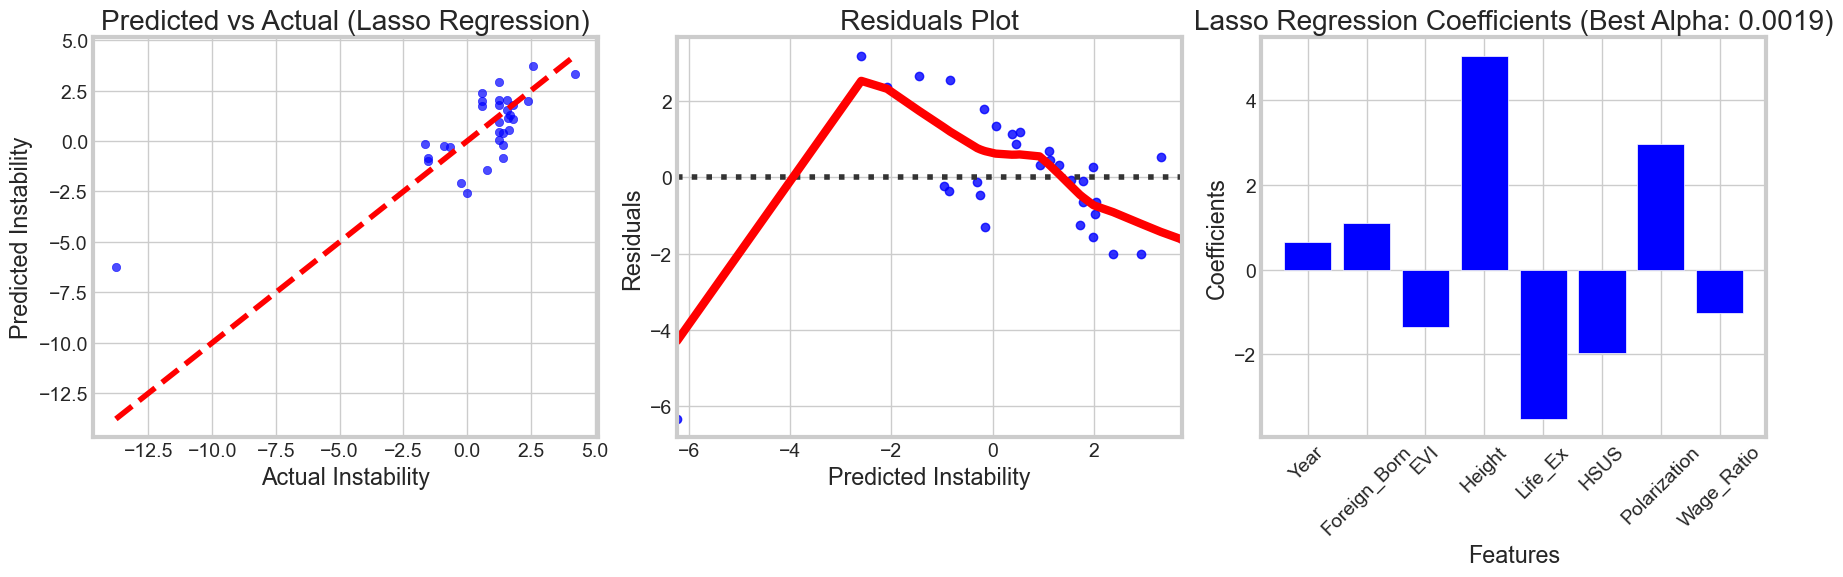

In [54]:
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Predicted vs Actual Plot
axes[0].scatter(y_test, y_preds, color='blue', alpha=0.7)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axes[0].set_xlabel('Actual Instability')
axes[0].set_ylabel('Predicted Instability')
axes[0].set_title('Predicted vs Actual (Lasso Regression)')

# Residuals Plot
residuals = y_test - y_preds
sns.residplot(x=y_preds, y=residuals, lowess=True, color='blue', line_kws={'color': 'red'}, ax=axes[1])
axes[1].set_xlabel('Predicted Instability')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals Plot')

# Coefficients Visualization
axes[2].bar(X.columns, lasso.coef_, color='blue')
axes[2].set_xlabel('Features')
axes[2].set_ylabel('Coefficients')
axes[2].set_title(f'Lasso Regression Coefficients (Best Alpha: {best_alpha.round(4)})')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## **Ridge Regression**

Mean Squared Error for Ridge Regression: 3.3065532046495245


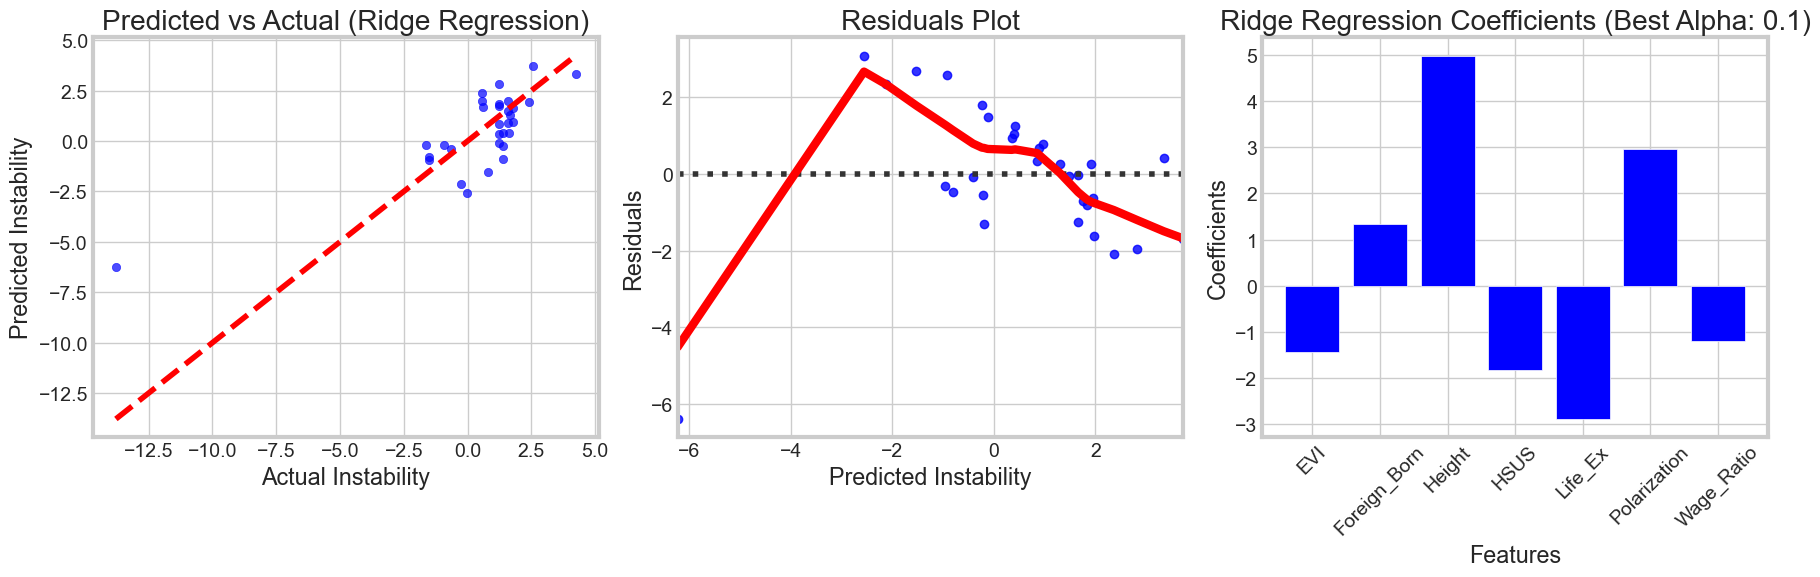

In [56]:
#| echo: false
from sklearn.linear_model import RidgeCV

X = clean_total_df[['EVI', 'Foreign_Born', 'Height', 'HSUS', 'Life_Ex', 'Polarization', 'Wage_Ratio']]
y = clean_total_df['Instability']

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

scaled_clean_df = pd.DataFrame(scaled_X, columns=X.columns)

#(80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(scaled_clean_df, y, test_size=0.2, random_state=42)

ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], store_cv_values=True)  # You can expand the list of alphas
ridge_cv.fit(X_train, y_train)

#best alpha found by RidgeCV
best_alpha = ridge_cv.alpha_
#print(f'Best Alpha: {best_alpha}')

y_pred = ridge_cv.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error for Ridge Regression: {mse}')
#print(f'Ridge Regression Coefficients: {ridge_cv.coef_}')


import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Predicted vs Actual Plot
axes[0].scatter(y_test, y_pred, color='blue', alpha=0.7)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axes[0].set_xlabel('Actual Instability')
axes[0].set_ylabel('Predicted Instability')
axes[0].set_title('Predicted vs Actual (Ridge Regression)')

# Residuals Plot
residuals = y_test - y_pred
sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue', line_kws={'color': 'red'}, ax=axes[1])
axes[1].set_xlabel('Predicted Instability')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals Plot')

# Coefficients Visualization
axes[2].bar(scaled_clean_df.columns, ridge_cv.coef_, color='blue')
axes[2].set_xlabel('Features')
axes[2].set_ylabel('Coefficients')
axes[2].set_title(f'Ridge Regression Coefficients (Best Alpha: {best_alpha})')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Based on the mean squared error, Lasso is slightly better than Ridge for this data.

## **Gradient Boost**

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3}
Best Cross-Validation Score: 2.1879735730417327
Mean Squared Error (Test Set): 6.235387180184161


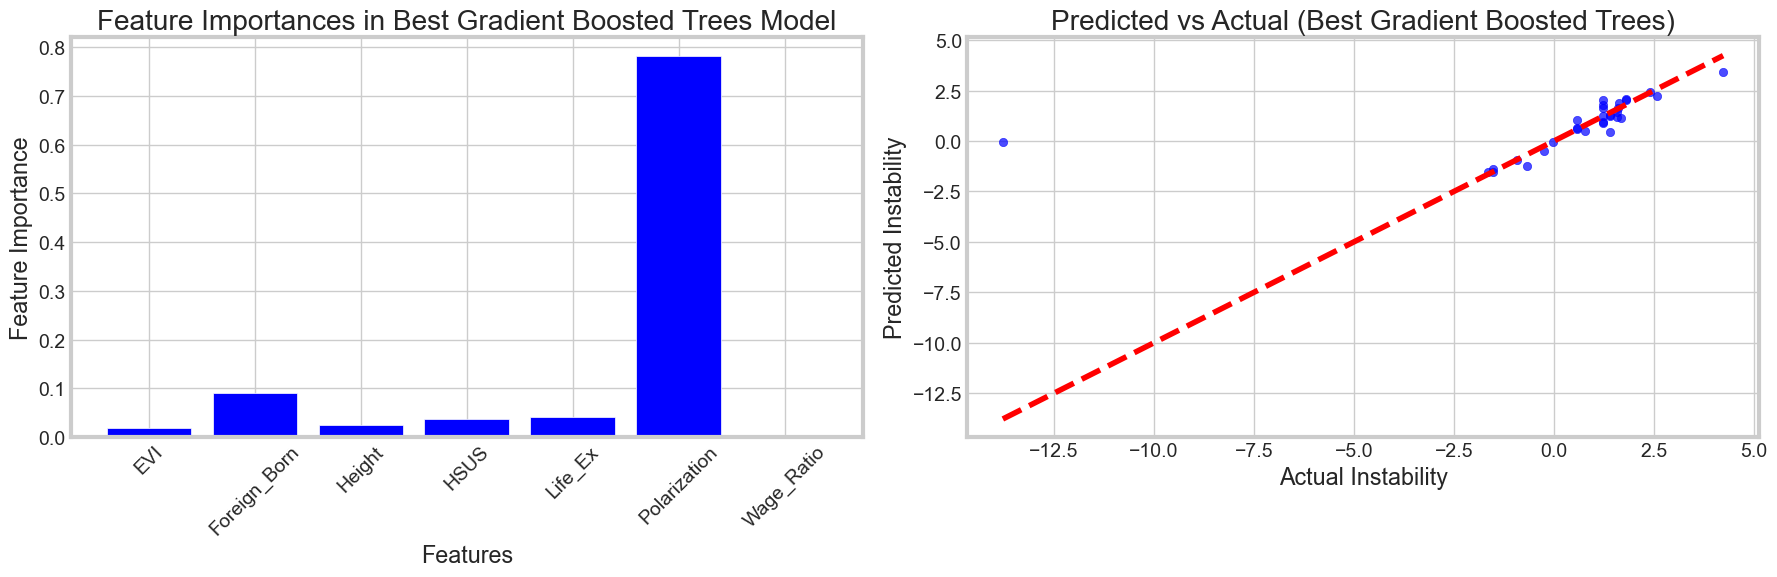

In [59]:
#| echo: false
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

gbt = GradientBoostingRegressor(n_estimators=100, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]}

grid_search = GridSearchCV(estimator=gbt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {-grid_search.best_score_}')

best_gbt = grid_search.best_estimator_
y_pred = best_gbt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Test Set): {mse}')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Feature Importance Plot
axes[0].bar(scaled_clean_df.columns, best_gbt.feature_importances_, color='blue')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Feature Importance')
axes[0].set_title(f'Feature Importances in Best Gradient Boosted Trees Model')
axes[0].tick_params(axis='x', rotation=45)

# Predicted vs Actual Plot
axes[1].scatter(y_test, y_pred, color='blue', alpha=0.7)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axes[1].set_xlabel('Actual Instability')
axes[1].set_ylabel('Predicted Instability')
axes[1].set_title('Predicted vs Actual (Best Gradient Boosted Trees)')

plt.tight_layout()
plt.show()

## **Random Forest**

In [61]:
#| echo: false
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

X = clean_total_df.drop(columns='Instability')
y = clean_total_df.Instability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train

In [62]:
#| echo: false
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the RandomForestRegressor model
random_forest_model = RandomForestRegressor()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest_model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and evaluate the model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")
#print(grid_search.best_estimator_)

# Train the model with the best parameters on the training data
best_random_forest_model =  grid_search.best_estimator_
best_random_forest_model.fit(X_train, y_train)

# Evaluate the model accuracy
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
predictions = best_random_forest_model.predict(X_test)

# Evaluate the model performance using MSE and R²
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error for Random Forest Regression: {mse}")
print(f"R-squared for Random Forest Regression: {r2}")

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error for Random Forest Regression: 1.939773334407733
R-squared for Random Forest Regression: 0.7668208112226682


In [63]:
#| echo: false
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set figure size to make the plot more readable
#plt.figure(figsize=(30, 20))

# Visualize the first tree from the trained Random Forest model
#plot_tree(
 #   best_random_forest_model.estimators_[0],  # Select the first tree from the forest
#    feature_names=X_train.columns,  # Add feature names for clarity
 #   filled=True,  # Color nodes based on class or regression value
 #   rounded=True,  # Rounded corners for nodes
 #   fontsize=12,  # Increase font size for better readability
 #   impurity=False,  # Remove impurity values for cleaner visualization
 #   precision=2,  # Set precision for numerical values in the tree (e.g., for splits and node values)
 #   proportion=True,  # Show proportion at each node (for classification tasks)
#)

# Set a title for the plot
#plt.title("Visualization of the First Decision Tree in the Random Forest", fontsize=16)

# Show the plot
#plt.show()


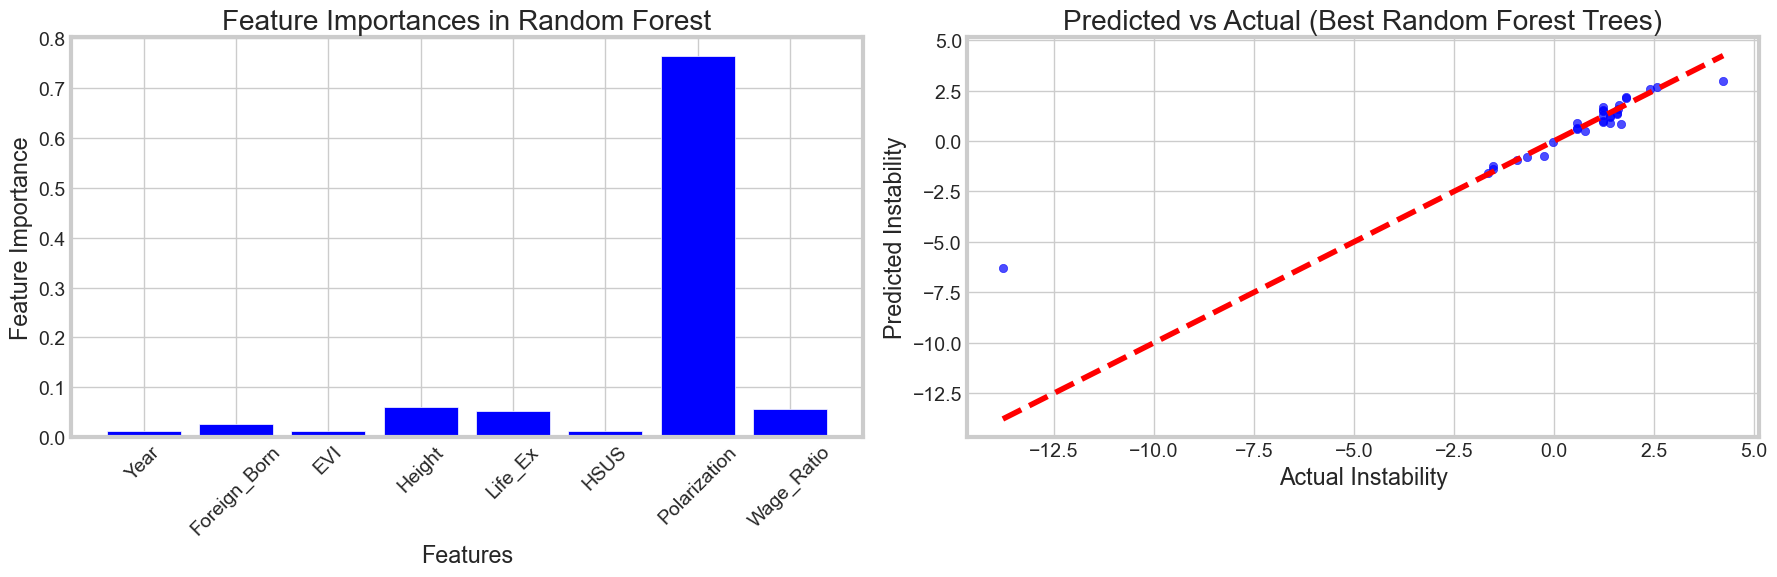

In [64]:
#| echo: false
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Feature Importance Plot
axes[0].bar(X.columns, best_random_forest_model.feature_importances_, color='blue')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Feature Importance')
axes[0].set_title(f'Feature Importances in Random Forest')
axes[0].tick_params(axis='x', rotation=45)

# Predicted vs Actual Plot
axes[1].scatter(y_test, predictions, color='blue', alpha=0.7)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axes[1].set_xlabel('Actual Instability')
axes[1].set_ylabel('Predicted Instability')
axes[1].set_title('Predicted vs Actual (Best Random Forest Trees)')

plt.tight_layout()
plt.show()

**Summary of conclusions:**

The evaluation of multiple models for predicting instability reveals that the random forest model performed best, achieving the lowest Mean Squared Error (MSE) of 1.94. This indicates that it produces the most accurate predictions compared to the other models. Notably, polarization emerged as the dominant predictor, with a high feature importance score of 0.78, while other features had much lower scores. The lasso and ridge regression models yielded similar results (MSEs of 3.26 and 3.3, respectively), with height, life expectancy, and polarization having the largest coefficients. However, their residual plots showed a negative linear trend, suggesting model misfit. Ideally, residuals should be scattered randomly around zero, indicating that the model has captured all patterns in the data. This clear trend in the residual plots suggests to us that the model might be missing some important feature relationships. Gradient boosting, despite being a non-linear model like random forest, underperformed with an MSE of 6.23, again highlighting polarization as the most critical feature. The superior performance of random forest suggests that a flexible, ensemble-based approach captures the complex relationships in the data better than linear models. The random forest model is an ensemble method, meaning it combines multiple decision trees to make predictions. Unlike linear models (like lasso and ridge regression), which assume a straight-line relationship between predictors and the target, random forests can model more complex, non-linear interactions. This flexibility allows random forests to adapt better to patterns in the data, which likely explains why it had the lowest MSE in this case.

## **Part IV: Find the best dimensionality reduction for regression.**

For this question, we will do dimensionality reduction using Principal Components Analysis (PCA) and Autoencoders. We decided PCA would be a good method to use because it scales well for large datasets and is effective at reducing a large number of features (like we have in this dataset) into a customizable number of features (here, we try out PCA with 2 components and 3 components). While PCA has the benefit of being easy to interpret, it assumes that there is a linear relationship between our features, which our data exploration does not support. For that reason, we also tried dimensionality reduction for regression with Autoencoders. This technique, while being more difficult to interpret, is good for complex, high-dimensional, and non-linear data. Autoencoders are able to capture more complicated relationships than PCA can, and so this technique is a valuable one to try on our dataset. We opted not to try out additional techniques, such as TSNE. TSNE is primarily used to visualize and explore high-dimensional datasets, rather than to make predictions, which is our task here.


For evaluating the performance of our models—PCA + Random Forest Regression and Autoencoders—we chose Mean Squared Error (MSE) and R² (coefficient of determination) because they provide complementary insights into model accuracy and explanatory power.

*Why MSE?*

MSE measures the average squared difference between predicted and actual values. It is particularly useful for regression problems because it penalizes larger errors more heavily, making it sensitive to significant mispredictions, and it is clearly interpretable measure of how far off the model’s predictions are on average. Since we applied dimensionality reduction (PCA) before using Random Forest, we need a reliable metric to assess whether reducing the number of features negatively impacts predictive accuracy. MSE helps quantify this loss.

*Why R²?*

R² indicates how well the model explains variance in the target variable. It is particularly useful when comparing models trained on transformed feature spaces (like PCA vs. raw data). For Autoencoders especially, R² is particularly valuable since they aim to reconstruct input data. A high R² suggests that the compressed representation retains key information, while a low R² might indicate excessive information loss.


By using MSE and R² together, we aim to get a balanced view of model performance, including absolute predictive accuracy and how well the model explains variance relative to the complexity of the dataset. These metrics help us determine whether reducing feature space improves efficiency without sacrificing too much predictive power.

### **Principal Components Analysis:**

**Principal Components Analysis with 2 components:**

In [71]:
#| echo: false
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [72]:
#| echo: false
PCA_df = clean_total_df.drop(columns = 'Instability')
#PCA_df

In [73]:
#| echo: false
scaler = StandardScaler()
X_scaled = scaler.fit_transform(PCA_df) 
#X_scaled

In [74]:
#| echo: false
model = PCA(n_components=2) # redundant now,  
model.fit(X_scaled)     # but good practice if 
                            # inverse_transform is required
pcs_df = model.transform(X_scaled)
PCA_df['PC1'] = pcs_df[:,0]
PCA_df['PC2'] = pcs_df[:,1]
# df['PC3'] = pcs_df[:,2]
# df['PC4'] = pcs_df[:,3]
new_features = ['PC1', 'PC2']
#PCA_df

In [75]:
#| echo: false
#print the cumulative variance
#print(model.explained_variance_ratio_.cumsum())
print("PC1 and PC2 together capture " + str((model.explained_variance_ratio_.cumsum()[1] * 100).round(2)) + "% of the variance.")

PC1 and PC2 together capture 89.83% of the variance.


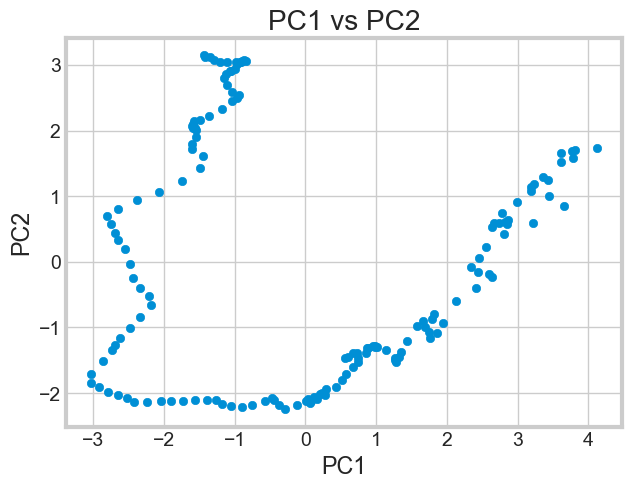

In [76]:
#| echo: false
plt.scatter(PCA_df['PC1'], PCA_df['PC2'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2")
plt.show()

In [77]:
#| echo: false
#see how PC1 and PC2 compare to original regressor (unreduced data).
#You can test your variables using the best regressor found in the previous section
#evaluation metric? - use same as before
X = PCA_df[new_features] #only using PC1 and PC2
y = clean_total_df.Instability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X

In [78]:
#| echo: false
#Retrain the Random Forest model on PC1 and PC2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the RandomForestRegressor model
random_forest_model = RandomForestRegressor()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest_model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and evaluate the model
best_params = grid_search.best_params_
#print(f"Best Parameters: {best_params}")
#print(grid_search.best_estimator_)

# Train the model with the best parameters on the training data
best_random_forest_model =  grid_search.best_estimator_
best_random_forest_model.fit(X_train, y_train)

# Evaluate the model accuracy
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
predictions = best_random_forest_model.predict(X_test)

# Evaluate the model performance using MSE and R²
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

#print(f"Mean Squared Error: {mse}")
#print(f"R-squared: {r2}")

Results from unreduced data: \
Mean Squared Error for Random Forest Regression: 1.939773334407733\
R-squared for Random Forest Regression: 0.7668208112226682

Results from Random Forest Regression retrained on PC1 and PC2:\
Mean Squared Error: 0.5611767921945501\
R-squared: 0.9325412166238773

**Compared to our unreduced data, these evaluation metrics are much better! We get a smaller MSE of 0.56, and a larger R-squared of 0.93.**

**PCA with 3 Components:**

In [81]:
#| echo: false
PCA_df3 = clean_total_df.drop(columns = 'Instability')
PCA_df3
scaler = StandardScaler()
X_scaled = scaler.fit_transform(PCA_df) 

model3 = PCA(n_components=3) # redundant now,  
model3.fit(X_scaled)     # but good practice if 
                            # inverse_transform is required
pcs_df3 = model3.transform(X_scaled)
PCA_df3['PC1'] = pcs_df3[:,0]
PCA_df3['PC2'] = pcs_df3[:,1]
PCA_df3['PC3'] = pcs_df3[:,2]
# df['PC4'] = pcs_df[:,3]
new_features = ['PC1', 'PC2', 'PC3']
#PCA_df3

In [82]:
#| echo: false
#print the cumulative variance
#print(model3.explained_variance_ratio_.cumsum())
print("PC1, PC2, and PC3 together capture " + str((model3.explained_variance_ratio_.cumsum()[1] * 100).round(2)) + "% of the variance.")

PC1, PC2, and PC3 together capture 91.86% of the variance.


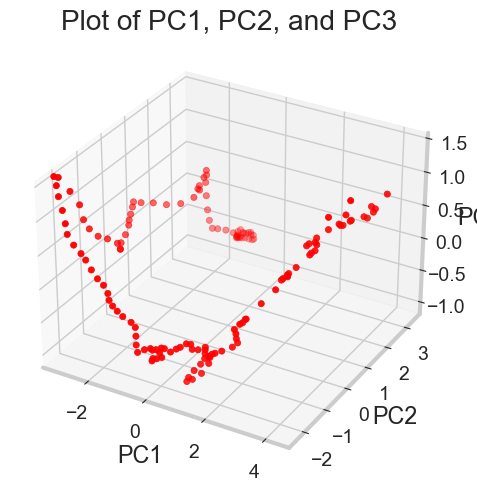

In [83]:
#| echo: false
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set the viewing angle to make sure the labels are not cut off
#ax.view_init(elev=20, azim=30)  # Adjust these values for better visibility

# Assuming PCA_df3 is your DataFrame containing the principal components
x = PCA_df3.PC1
y = PCA_df3.PC2
z = PCA_df3.PC3

# Create a figure
fig = plt.figure()

# Add 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the points
ax.scatter(x, y, z, c='r', marker='o')  # You can change the color and marker style

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xlim([min(x), max(x)])
ax.set_ylim([min(y), max(y)])
ax.set_zlim([min(z), max(z)])

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Show the plot
plt.tight_layout()
plt.title("Plot of PC1, PC2, and PC3")
plt.show()

In [84]:
#| echo: false
#see how PC1 and PC2 compare to original regressor (unreduced data). fit new RF Regressor model with the PCs
X = PCA_df3[new_features] #only using PC1 and PC2 and PC3
y = clean_total_df.Instability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X

In [85]:
#| echo: false
#Retrain the Random Forest model on PC1 and PC2 and PC3
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the RandomForestRegressor model
random_forest_model = RandomForestRegressor()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest_model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and evaluate the model
best_params = grid_search.best_params_
#print(f"Best Parameters: {best_params}")
#print(grid_search.best_estimator_)

# Train the model with the best parameters on the training data
best_random_forest_model =  grid_search.best_estimator_
best_random_forest_model.fit(X_train, y_train)

# Evaluate the model accuracy
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
predictions = best_random_forest_model.predict(X_test)

# Evaluate the model performance using MSE and R²
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

#print(f"Mean Squared Error: {mse}")
#print(f"R-squared: {r2}")

Comparing the results: \
Results from unreduced data: \
Mean Squared Error for Random Forest Regression: 1.939773334407733\
R-squared for Random Forest Regression: 0.7668208112226682

Results from Random Forest Regression retrained on PC1 and PC2:\
Mean Squared Error: 0.5611767921945501\
R-squared: 0.9325412166238773

Results from Random Forest model retrained on PC1, PC2, and PC3: \
Mean Squared Error: 0.3518668926979168 \
R-squared: 0.957702255649394 

**Reducing dimensionality to 3 and building a Random Forest regressor on these 3 PCs resulted in the best results. MSE went down to 0.35 and R-squared increased to 0.958.**

**AUTOENCODERS for n=2 and n=3** 

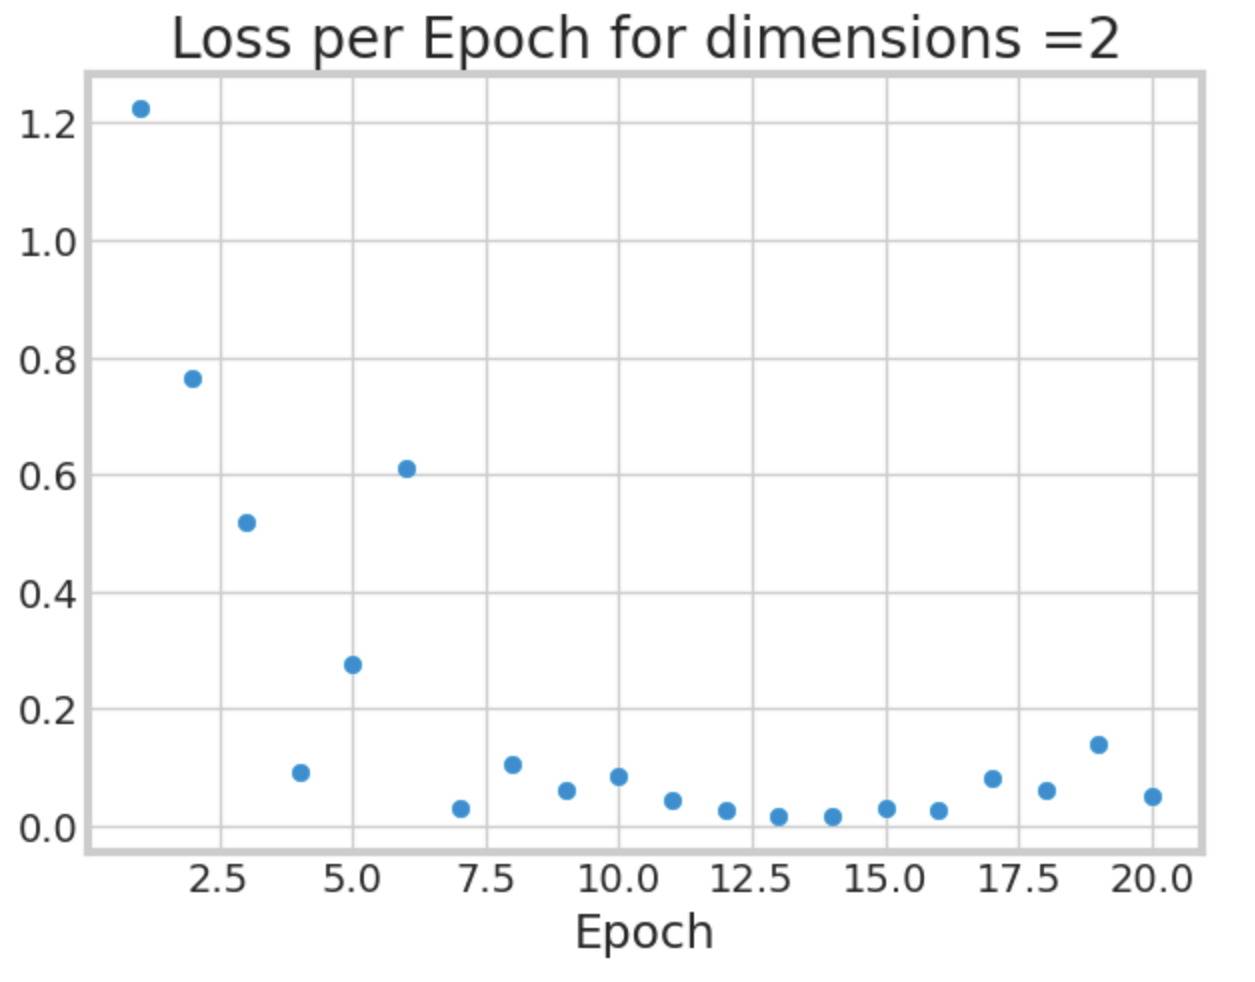

In [88]:
#| echo: false
from IPython.display import Image
Image(filename='2d.png',width=400, height=400)

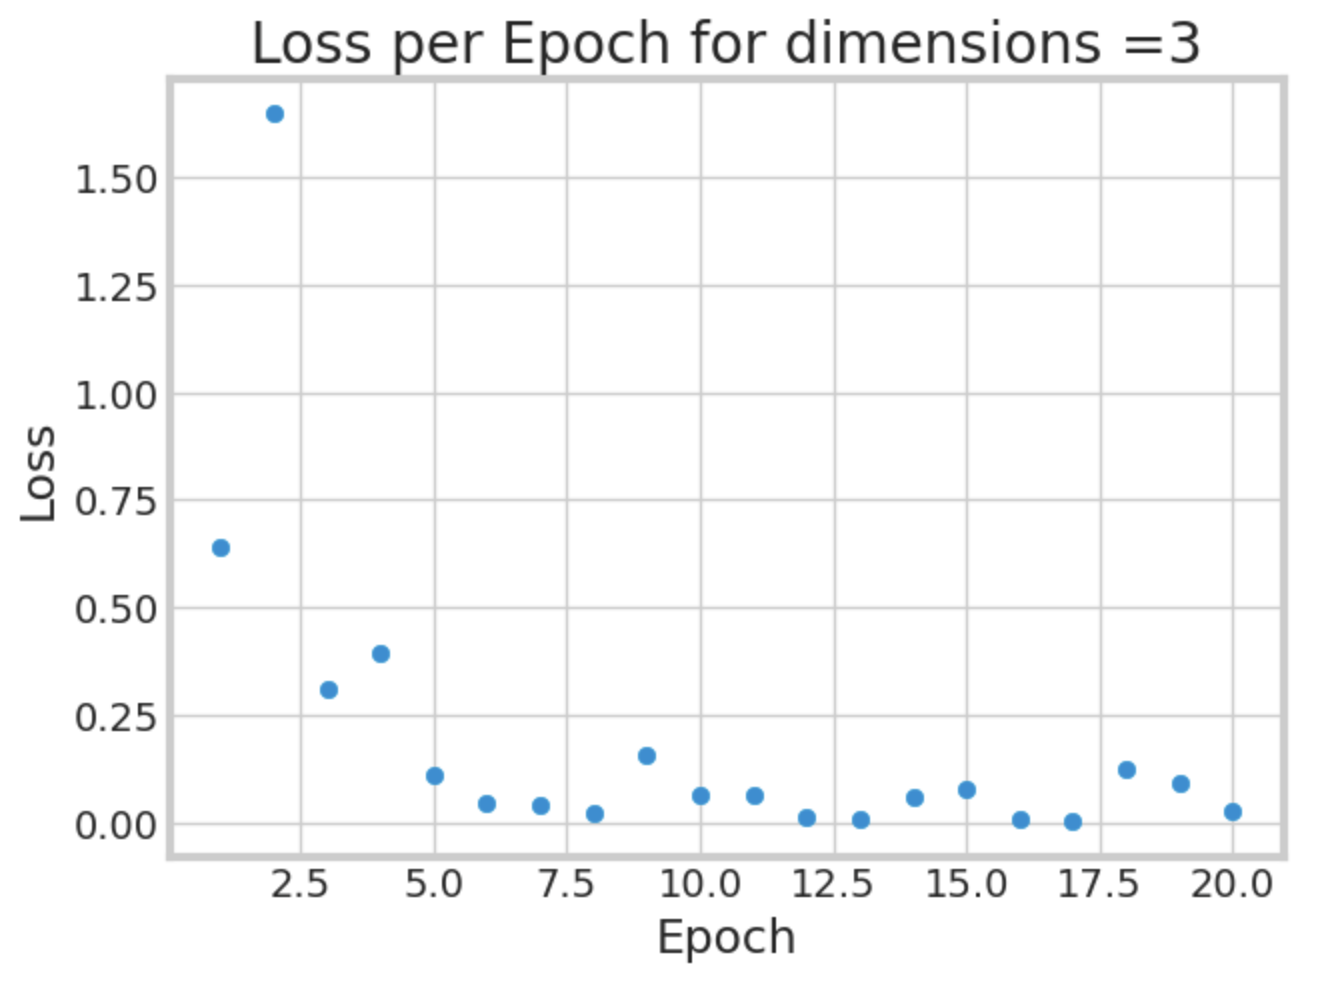

In [89]:
#| echo: false
from IPython.display import Image
Image(filename='3d.png',width=400, height=400)

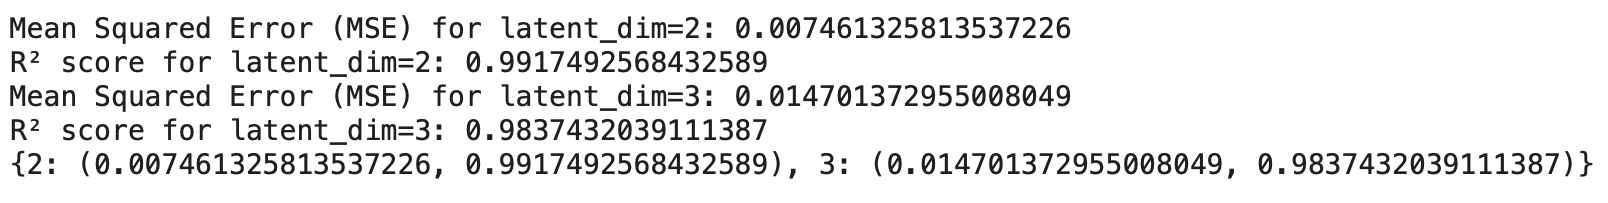

In [90]:
#| echo: false
from IPython.display import Image
Image(filename='results.png',width=450, height=100)

**Summary of conclusions:**

After training the autoencoder twice—once with 2 dimensions and once with 3 dimensions—we find that the 2-dimensional dimensionality reduction worked best with an MSE of 0.007 and an R² of 0.992. 

Compared to the MSE and R² results from PCA with 3 components, the Autoencoder performs better. Our optimal result from PCA was an MSE of 0.35 and an R-squared of 0.958. Both Autoencoder models (n=2 and n=3) outperform our PCA models. This may be because Autoencoders are particularly good at modeling non-linear relationships in data and capturing patterns and relationships that are more complex. PCA, on the other hand, is a linear method. Our data, as we saw earlier, is not very linear. Practically, though, PCA is easier to interpret and easier to run on our laptops (our kernels kept crashing when using Autoencoders), so we will proceed with PCA for dimensionality reduction in the next problem.

## **Part V: Find the best dimensionality reduction for unsupervised classification.**

In [94]:
#| echo: false
#trying a k means model
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

For this section, we will test both 2D and 3D PCA and then use k-means to test our variables. Since the goal is unsupervised classification (without using the outcome variable), K-means is a natural choice as it clusters data based purely on patterns in the predictor variables. By applying K-means to the reduced-dimensional data, we can assess how well the selected features contribute to meaningful groupings.

**KMeans on PCA with 2 components**

In [97]:
#| echo: false
#PCA_df[['PC1','PC2']]

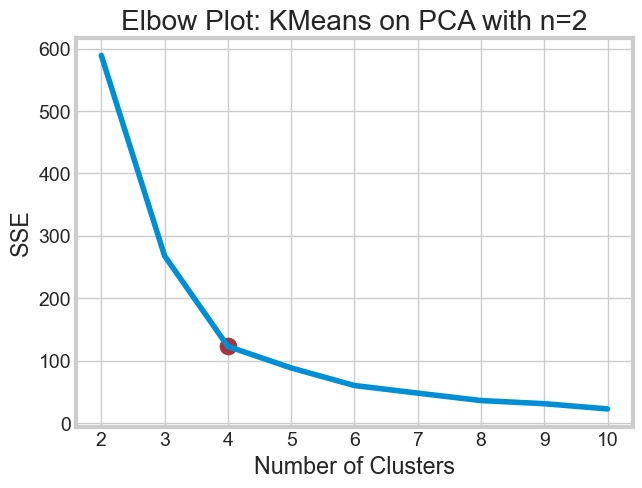

In [98]:
#| echo: false
#########################
# Find k - elbow method #
#########################

features = ['PC1', 'PC2']
kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300}

k_vals = list(range(2, 11))
sse = []
for k in k_vals:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(PCA_df[features])
    sse.append(kmeans.inertia_)
    
kl = KneeLocator(k_vals, sse, curve='convex', 
                 direction='decreasing')
#print('Automatically found elbow at %d clusters.'%kl.elbow)

plt.plot(k_vals, sse)
plt.title('Elbow Plot: KMeans on PCA with n=2')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')  
plt.scatter(kl.elbow, kl.elbow_y, s=150, c='#a8323e');

In [99]:
#| echo: false
n_clusters = 4
kmeans = KMeans(init='random', n_clusters=n_clusters,
                n_init=10, max_iter=300)
kmeans.fit(PCA_df[['PC1','PC2']])
#print('The lowest SSE value found: %.3f'%kmeans.inertia_)
#print('The number of iterations required to converge: %d'%\
     # kmeans.n_iter_)

KMeans(init='random', n_clusters=4, n_init=10)

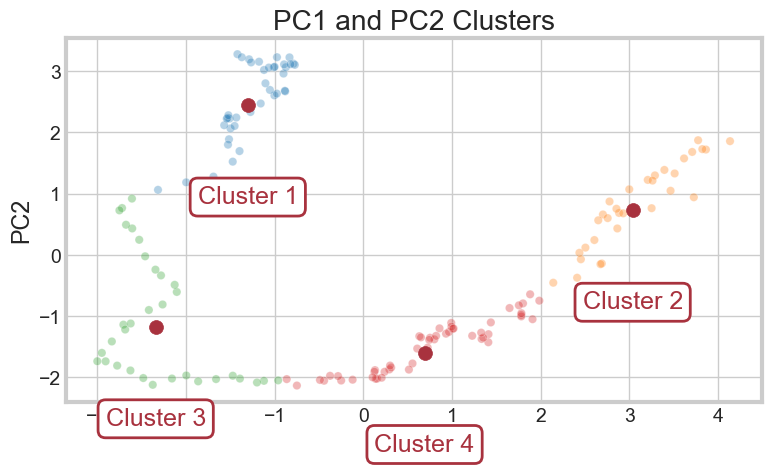

In [100]:
#| echo: false
features = ['PC1', 'PC2']
fig, ax = plt.subplots(figsize=(8, 4.5))
plt.title("PC1 and PC2 Clusters")

# Plot and add jitter for better visualization
ax = sns.scatterplot(ax=ax, 
                x=PCA_df[features[0]]+np.random.rand(len(PCA_df))*0.1, 
                y=PCA_df[features[1]]+np.random.rand(len(PCA_df))*0.2,
                hue=kmeans.labels_, 
                palette=sns.color_palette('tab10', 
                                          n_colors=n_clusters),
                legend=None, alpha = 0.33)

for n, [dur, qual] in enumerate(kmeans.cluster_centers_):
    ax.scatter(dur, qual, s=100, c='#a8323e')
    ax.annotate('Cluster %d'%(n+1), (dur, qual), fontsize=18,
                color='#a8323e', xytext=(dur, qual-1.5),
                bbox=dict(boxstyle='round,pad=0.3', 
                          fc='white', ec='#a8323e', lw=2),
                ha='center', va='center');



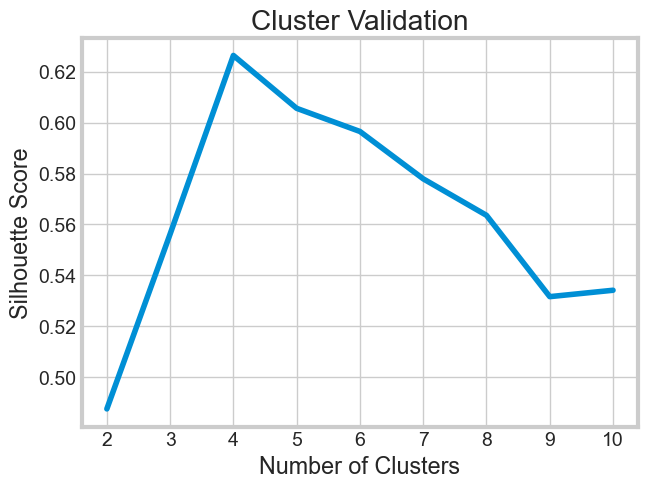

In [101]:
#| echo: false
#Cluster Validation
features = ['PC1', 'PC2']
silhouette_coefficients = []

# The average silhouette coefficient of all the samples 
# is summarized into one score.
silhouette_coefficients = []
for k in k_vals:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(PCA_df[features])
    score = silhouette_score(PCA_df[features], kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.plot(k_vals, silhouette_coefficients)
plt.title("Cluster Validation")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');


**KMeans on PCA with 3 components**

In [103]:
#| echo: false
new_features = ['PC1', 'PC2', 'PC3']
#PCA_df3

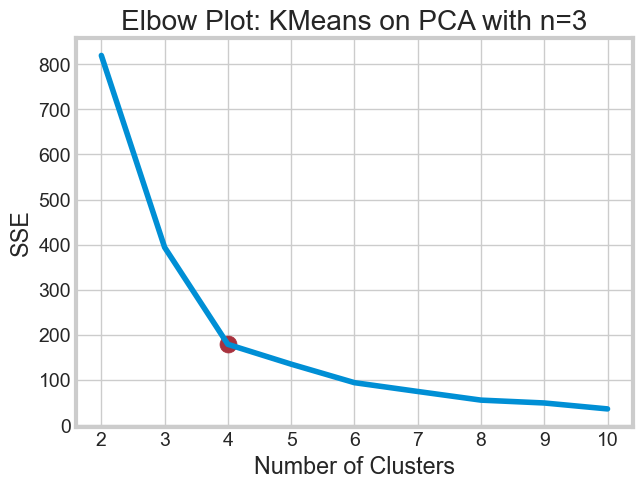

In [104]:
#| echo: false
#########################
# Find k - elbow method #
#########################

new_features = ['PC1', 'PC2', 'PC3']
kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300}

k_vals = list(range(2, 11))
sse = []
for k in k_vals:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(PCA_df3[new_features])
    sse.append(kmeans.inertia_)
    
kl = KneeLocator(k_vals, sse, curve='convex', 
                 direction='decreasing')
#print('Automatically found elbow at %d clusters.'%kl.elbow)

plt.plot(k_vals, sse)
plt.xlabel('Number of Clusters')
plt.title('Elbow Plot: KMeans on PCA with n=3')
plt.ylabel('SSE')  
plt.scatter(kl.elbow, kl.elbow_y, s=150, c='#a8323e');

In [105]:
#| echo: false
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 4

# Fit the KMeans model
kmeans = KMeans(init='random', n_clusters=n_clusters, n_init=10, max_iter=300)
kmeans.fit(PCA_df3[['PC1', 'PC2', 'PC3']])

# Print the SSE and number of iterations
#print(f'The lowest SSE value found: {kmeans.inertia_:.3f}')
#print(f'The number of iterations required to converge: {kmeans.n_iter_}')

KMeans(init='random', n_clusters=4, n_init=10)

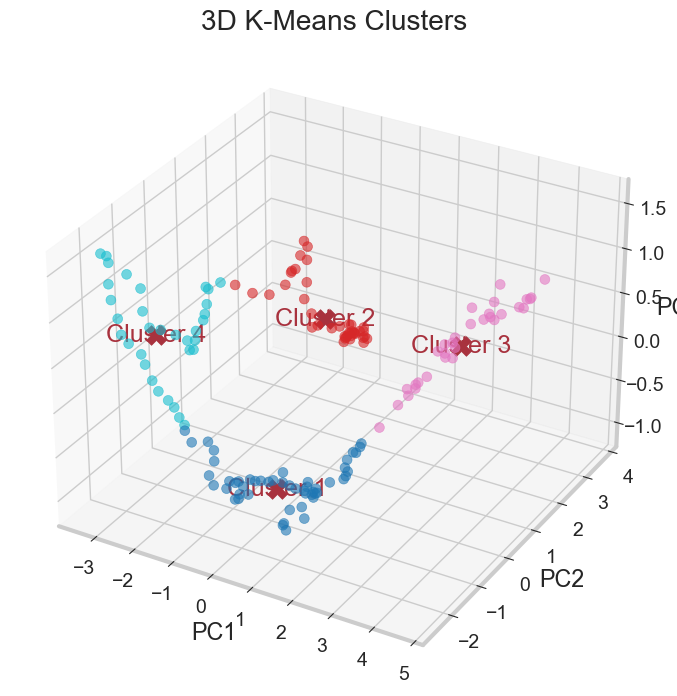

In [106]:
#| echo: false
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plt.title('PC1, PC2, and PC3 Clusters')

# Plot data points with jitter
ax.scatter(PCA_df3['PC1'] + np.random.rand(len(PCA_df3)) * 0.1, 
           PCA_df3['PC2'] + np.random.rand(len(PCA_df3)) * 0.2,
           PCA_df3['PC3'] + np.random.rand(len(PCA_df3)) * 0.1, 
           c=kmeans.labels_, 
           cmap='tab10', alpha=0.6, s=50)

# Plot cluster centers
for i, (x, y, z) in enumerate(kmeans.cluster_centers_):
    ax.scatter(x, y, z, s=200, c='#a8323e', marker='X')  # Cluster centers
    ax.text(x, y, z, f'Cluster {i+1}', fontsize=18, color='#a8323e', ha='center', va='center')

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D K-Means Clusters')

# Show plot
plt.show()

Text(0, 0.5, 'Silhouette Score')

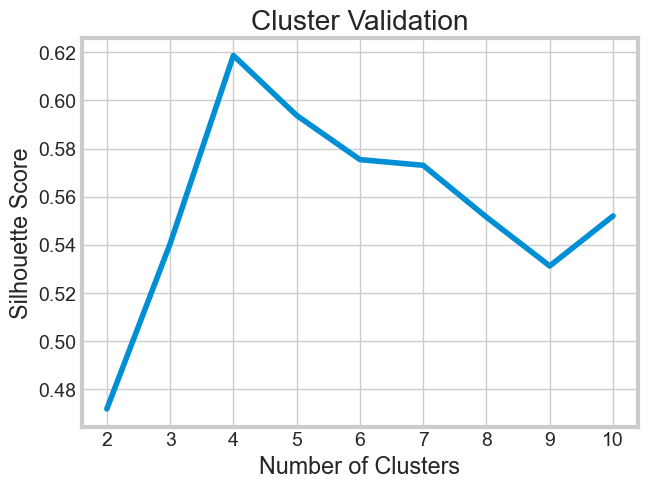

In [107]:
#| echo: false
# Cluster Validation
new_features = ['PC1', 'PC2', 'PC3']
silhouette_coefficients = []

# The average silhouette coefficient of all the samples 
# is summarized into one score.
silhouette_coefficients = []
for k in k_vals:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(PCA_df3[new_features])
    score = silhouette_score(PCA_df3[new_features], kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.plot(k_vals, silhouette_coefficients)
plt.title("Cluster Validation")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')


We found that the 2D clustering worked better since the lowest SSE found for 2D clustering was 122.798 and for 3D clustering it was 178.92. The Sum of Squared Errors (SSE) measures how tightly the data points are grouped around their cluster centers—the lower the SSE, the better the clustering. Our results suggest that the clusters in the 2D space are more compact and well-separated, while the extra dimension in the 3D space might have introduced unnecessary complexity or noise. In practical terms, this means that using two dimensions for clustering provides clearer, more meaningful groupings of the data compared to using three dimensions.

When considering the 2D plot itself, we note that the clusters are not spherical and they are not very well-separated (although they do not overlap, which is good). These two things indicate to use that the k-means algorithm is not the best clustering method, or that the data does not separate well in the reduced 2D space. However, looking at our results in the 3D space does not change this because the clusters are still lines. The clusters are still not dense -- which suggests more variability -- and are stretched out -- which also signals that k-means might not be the best method for our data. 

These observations made us decide to do cluster validation using Silhouette Score to measure how well the data is grouped. Our aim was to assess whether the number of clusters is appropriate or if another value would give better separation. The silhouette score calculates the "separation" of a data point from its own cluster compared to the nearest cluster, relying on the distances between data points, so the standardization of the data that we did before PCA is sufficient and we do not need to standardize again. The silhouette graph (number of clusters vs. silhouette score) of the reduced 2D space shows that choosing 4 clusters was a good decision because that maximizes the silhouette score. The maximum score that the silhouette score graph got up to was 0.625, which is acceptable (on the scale from -1 to 1, a score between 0.5 and 0.7 is considered moderately good and acceptable for most tasks) since it suggests that the clusters are well-separated and that points are relatively well-assigned to the appropriate clusters. The silhouette graph of the reduced 3D space shows that choosing 4 clusters was a good decision because that maximizes the silhouette score. Similarly to the 2D plot, the maximum score that the silhouette score graph got up to was 0.62, which is also acceptable although slightly worse.

It's interesting that for dimensionality reduction for regression, it was useful to include more components in PCA. However, when we used k-means, PCA with only 2 components was better.

## **Part VI: Briefly explore the clusters of instability scores.**

We used the cluster labels from the 2D k-means to apply to the corresponding records of the outcome column (Political Instability Index or PII). We combined all of the columns (scaled) including PCA1 and PCA2 and Label (our cluster label). Then, we created a scatterplot of Instability versus Labels in order to see if the clusters exhibit a discernable or interpretable pattern. However, because the labels are discrete (0, 1, 2, 3) this visualization was not very easily interpretable -- although we could tell that there was overlap on the Instability (y-axis) between the labels and that there is one outlier for cluster 1. In order to make the scatterplot easier to interpret, we color-coded the different labels. We also wanted to see the distribution of the different clusters, so we created a box plot to tell us more about each cluster.

In [111]:
#| echo: false
#using clustering with 2 components, 4 clusters
#group by cluster, add instability scores
n_clusters = 4
kmeans = KMeans(init='random', n_clusters=n_clusters,
                n_init=10, max_iter=300)
kmeans.fit(PCA_df[['PC1','PC2']])
#print('The lowest SSE value found: %.3f'%kmeans.inertia_)
#print('The number of iterations required to converge: %d'%\
      #kmeans.n_iter_)

KMeans(init='random', n_clusters=4, n_init=10)

In [112]:
#| echo: false
labels = kmeans.labels_

In [113]:
#| echo: false
clean_total_df["PC1"] = PCA_df.PC1
clean_total_df["PC2"] =  PCA_df.PC2
clean_total_df["Labels"] = labels
clean_total_df["Year_Unstd"] = PCA_df.Year
#clean_total_df

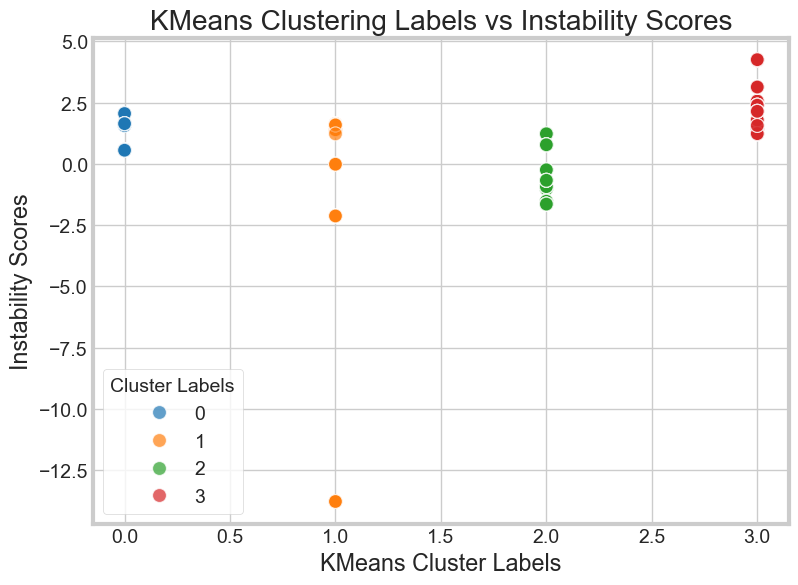

In [114]:
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming clean_total_df contains the KMeans labels in 'Labels' and the Instability scores in 'Instability'
plt.figure(figsize=(8, 6))

# Scatter plot with KMeans labels as colors
sns.scatterplot(x=clean_total_df['Labels'], 
                y=clean_total_df['Instability'], 
                hue=clean_total_df['Labels'],  # Color by cluster label
                palette='tab10',  # Choose a color palette
                alpha=0.7,  # Adjust transparency
                s=100)  # Size of the points

# Customize the plot
plt.title('KMeans Clustering Labels vs Instability Scores')
plt.xlabel('KMeans Cluster Labels')
plt.ylabel('Instability Scores')
plt.legend(title='Cluster Labels', loc='best')
plt.show()


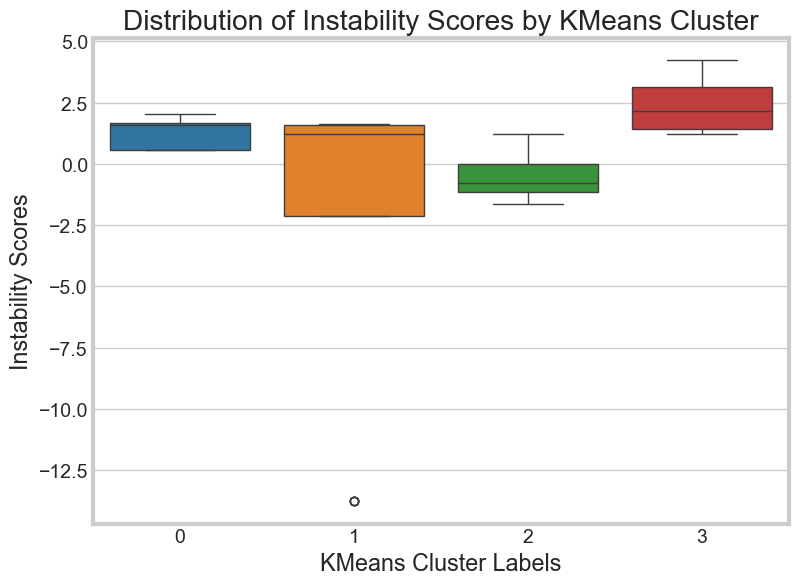

In [115]:
#| echo: false
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to show the distribution of Instability within each cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='Labels', y='Instability', data=clean_total_df, palette='tab10')

# Customize the plot
plt.title('Distribution of Instability Scores by KMeans Cluster')
plt.xlabel('KMeans Cluster Labels')
plt.ylabel('Instability Scores')
plt.show()

From the scatterplot and box plots, we can see that the clusters overlap with each other on the instability scores and there is no clear pattern. This makes us wonder *why* the clusters were grouped this way. In order to explore that, we created boxplots of each feature versus the cluster labels assigned to the datapoints. All of the boxplots below showed overlap in their distributions aside from one—cluster versus year, which had distinct groupings for each cluster. Additionally, unlike many of the clusters for the other features, the cluster distributions for Year are all relatively equally sized and relatively compact. 

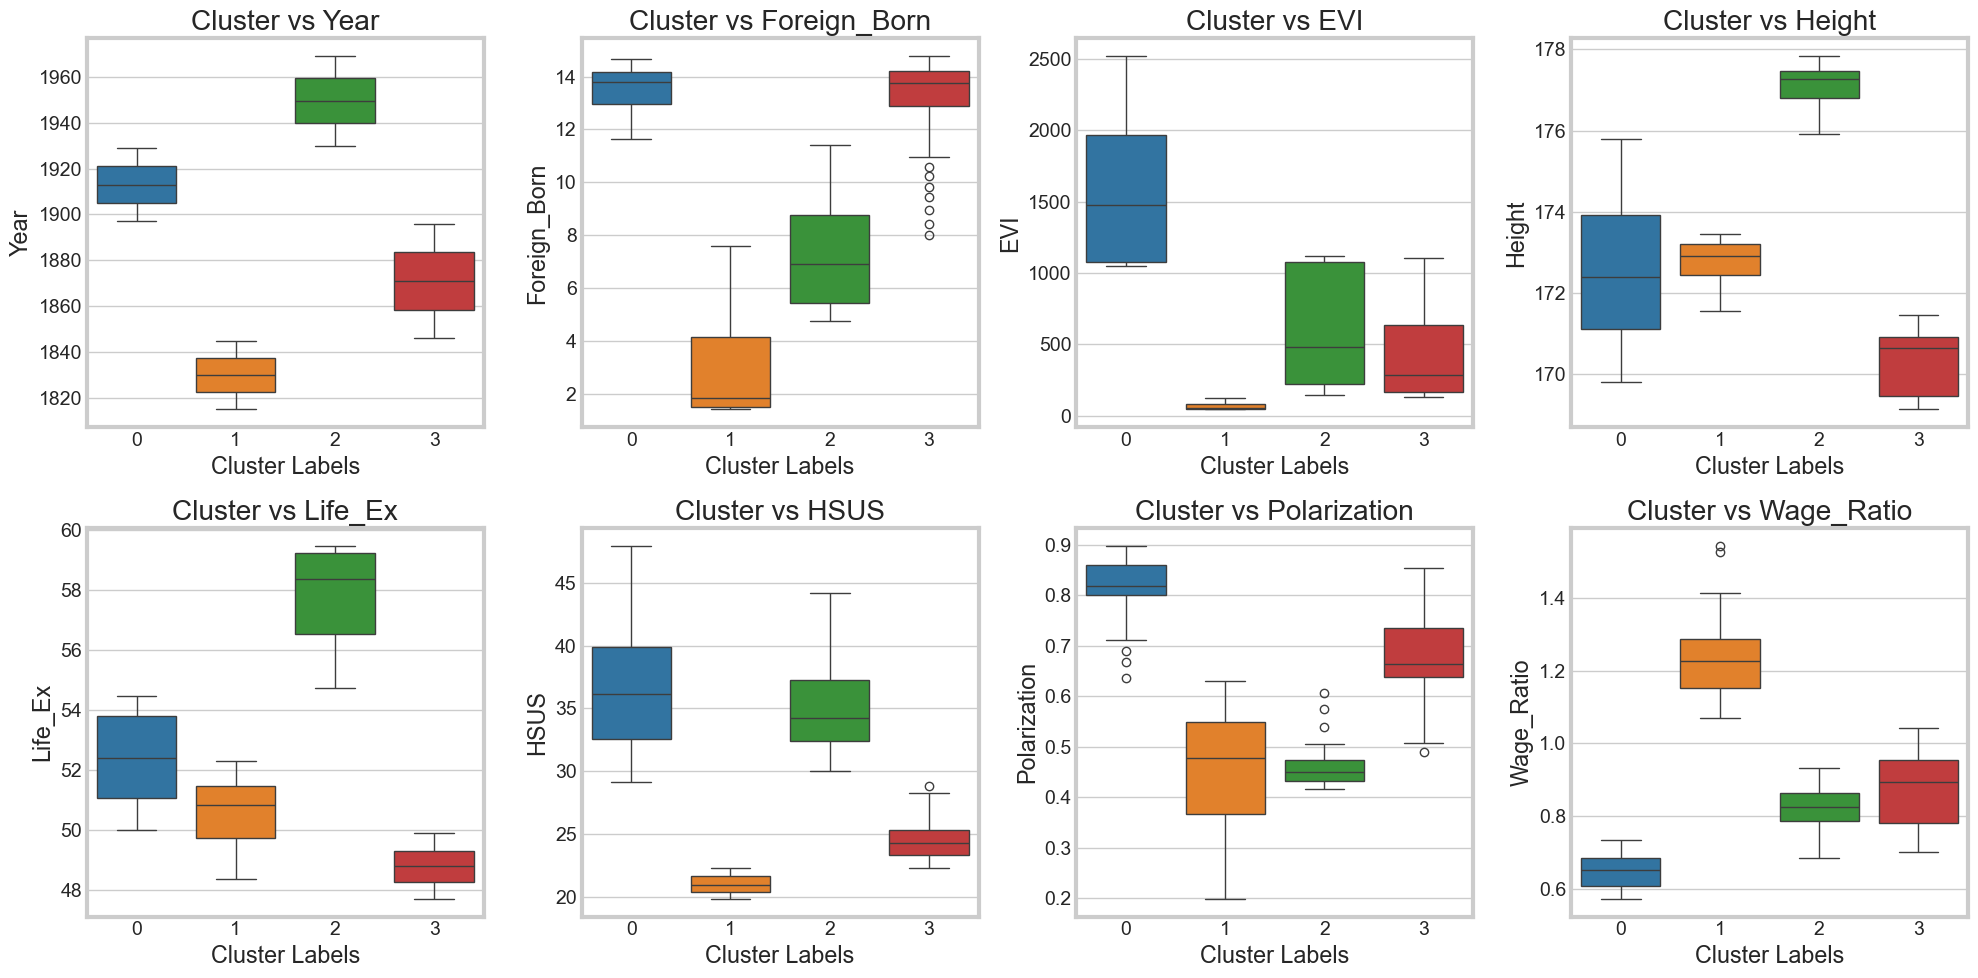

In [117]:
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns

# List of variables to compare with cluster labels
variables = ['Year', 'Foreign_Born', 'EVI', 'Height', 'Life_Ex', 'HSUS', 'Polarization', 'Wage_Ratio']

# Create a grid of plots (2 rows x 4 columns in this case)
# Adjust the number of rows and columns if necessary
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Flatten the axes array for easy access
axes = axes.flatten()

# Iterate through the variables and create a plot for each
for i, var in enumerate(variables):
    sns.boxplot(x='Labels', y=var, data=clean_total_df, hue='Labels', palette='tab10', ax=axes[i], legend=False)
    axes[i].set_title(f'Cluster vs {var}')
    axes[i].set_xlabel('Cluster Labels')
    axes[i].set_ylabel(var)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


The facts described above indicate that our model was clustering based on year. We created an additional visualization below to confirm this.

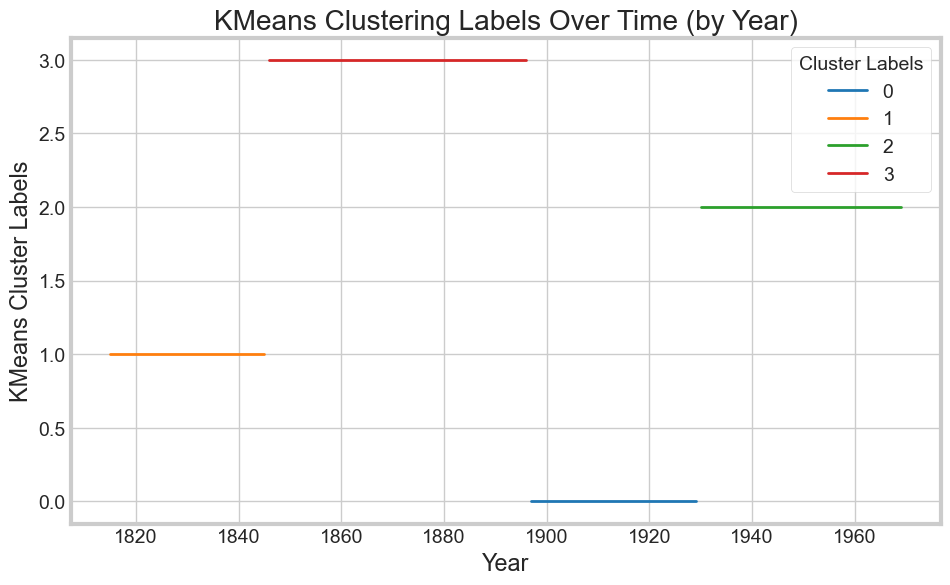

In [119]:
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming clean_total_df contains the KMeans labels in 'Labels' and 'Year'
plt.figure(figsize=(10, 6))

# Line plot where 'Year' is on the x-axis and 'Labels' (KMeans clusters) is on the y-axis
sns.lineplot(data=clean_total_df, 
             x='Year', 
             y='Labels', 
             hue='Labels',  # Color by cluster label
             palette='tab10',  # Choose a color palette
             markers=True,     # Add markers to the line
             linewidth=2,      # Line width
             markersize=8)     # Marker size

# Customize the plot
plt.title('KMeans Clustering Labels Over Time (by Year)')
plt.xlabel('Year')
plt.ylabel('KMeans Cluster Labels')
plt.legend(title='Cluster Labels', loc='best')
plt.show()


Now, we are curious about how instability values changes over time, and we maintained color-coded clusters in the visualization below.

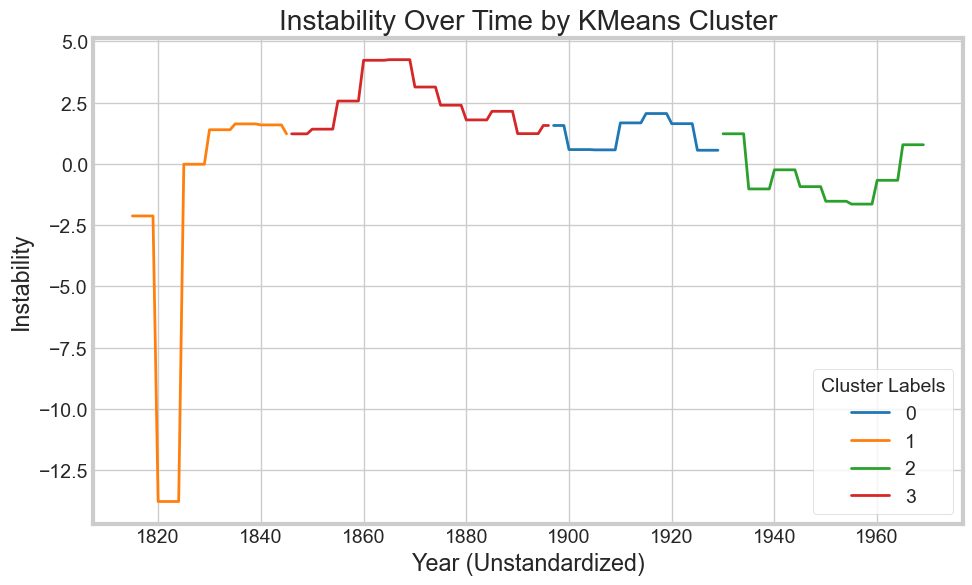

In [121]:
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Line plot where 'Year_Unstd' is on the x-axis and 'Instability' is on the y-axis, colored by 'Labels'
sns.lineplot(data=clean_total_df, 
             x='Year_Unstd', 
             y='Instability', 
             hue='Labels',  # Color by KMeans cluster labels
             palette='tab10',  # Choose a color palette
             linewidth=2,  # Line width
             markers=True,  # Add markers to each data point for clarity
             markersize=8)  # Marker size for each data point

# Customize the plot
plt.title('Instability Over Time by KMeans Cluster')
plt.xlabel('Year (Unstandardized)')
plt.ylabel('Instability')
plt.legend(title='Cluster Labels', loc='best')
plt.show()


## **Part VII: Consider a real life modeling/prediction problem**

Aside from considering how long it would take to run hundreds or thousands of models and how much computing power it would require, one potential disadvantage of this approach is that different models might perform better on different metrics. So, there might not be one best metric to use to evaluate all models in all situations. Depending on the goal of our analysis, our computing power, and how easily interpretable we would like our model to be, among other factors, we might select different metrics and models in different situations.

Another potential disadvantage is that we select a model which works very well on the training data, but is overfitted and does not perform well in the real world. To mitigate this risk, we could select the best model not just based on validation performance alone, but also by testing each model on a completely separate test set that was not used during model selection.

A third potential disadvantage is that we select a model which performed the best due to chance. We could use statistical techniques like false discovery rate or the Bonferroni adjustment to estimate how often our finding (of the best model based on performance) is a false positive and reduce the likelihood of false positives when multiple hypothesis tests are performed. We could also examine each model with multiple trials to try to prevent this from occurring.

## **Part VIII: Thank You!**

Hi Professor Jotte,\
Thank you so much for a great class! We really enjoyed it, learned a lot, and always felt comfortable approaching you with questions. We so appreciated all the time and effort you put into individual feedback and instruction. Even though the midterm kicked our butts, we had a great time and thought the TAs also did a fantastic job. Thank you again!\
From Constance and Caroline